In [17]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from Bio import SeqIO
import re
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from Bio.SubsMat import MatrixInfo as matlist
from Bio import pairwise2

from tensorflow import Tensor
import pickle


In [18]:
PC6_table = pd.read_csv('6-pc.', sep=' ', index_col=0)

  
Min_Max_Scaler = MinMaxScaler( feature_range=(-1,1)) 
Scaled_PC6_table = Min_Max_Scaler.fit_transform(PC6_table) 

amino = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
Scaled_PC6_table_labeled = {}
Scaled_PC6_table_labeled['X'] = np.array([0,0,0,0,0,0])
for index,item in enumerate(amino):
    Scaled_PC6_table_labeled[item] = Scaled_PC6_table[index,:]

In [19]:
def read_fasta(fasta_fname):
    r = dict()
    for record in SeqIO.parse(fasta_fname, 'fasta'):
        idtag = str(record.id)
        seq = str(record.seq)
        r[idtag] = seq
    return r


def padding_seq(r,length = 30 ,pad_value='X'):
    data={}
    for key, value in r.items():
        if len(r[key]) < length:
            data[key] = r[key]+pad_value*(length-len(r[key]))
            
    return data
    

def new_idea_encoding(data,table):
    dat={}
    for key in data.keys():
        integer_encoded = []
        for amino in list(data[key]):
            integer_encoded.append(table[amino])
        dat[key]=integer_encoded
    return dat


class FastaEncoding:
    def __init__(self,table,padding_seq_wrapper=None):
        self._table = table
        self._padding_seq_wrapper = padding_seq_wrapper or padding_seq
    def __call__(self,fasta_name):
        r = read_fasta(fasta_name)
        data = self._padding_seq_wrapper(r)
        dat = new_idea_encoding(data,self._table)
        return dat

def PC_6(fasta_name):
    return FastaEncoding(Scaled_PC6_table_labeled)(fasta_name)



data_PC6_dic = PC_6('4db_independent_6623.fasta')

data_PC6_array = np.array(list(data_PC6_dic.values())).astype(float)


data_PC6_array = np.expand_dims(data_PC6_array, axis=1) 

data_PC6_array.shape


(3195, 1, 30, 6)

In [20]:
workers = 2
batch_size = 128
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 60000
lr = 0.0001 
beta1 = 0   
beta2 = 0.9  
ngpu = 4

In [21]:
data_tensor = torch.Tensor(data_PC6_array) 
dataset = torch.utils.data.TensorDataset(data_tensor) 
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last=True)

In [22]:
device = torch.device("cuda:1" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [23]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [24]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu                                              
        self.main = nn.Sequential(
           
            nn.ConvTranspose2d( nz, ngf * 8, (5,1), (1,1), (0,0), bias=False),     
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
           
            nn.ConvTranspose2d( ngf * 8, ngf * 4, (4,1), (2,1), (1,0), bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf* 2, (8,1),(1,1), (1,0), bias=False),
            nn.BatchNorm2d(ngf* 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, (4,1),(2,1), (1,0), bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, (1,6),(1,1), (0,0), bias=False),   
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)

In [25]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, (1,6), (1,1), (0,0), bias=False),    
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, (4,1), (2,1), (1,0), bias=False),                                 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4,(8,1), (1,1), (1,0), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, (4,1), (2,1), (1,0), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, (5,1), (1,1), (0,0), bias=False),   
        )

    def forward(self, input):
        return self.main(input)

In [26]:
LAMBDA = 10
use_cuda = torch.cuda.is_available()

def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(batch_size,1)
    alpha = alpha.expand(real_data.permute(2,3,0,1).size())
    alpha = alpha.cuda(device) if use_cuda else alpha  
    
    fake_data = fake_data.permute(2,3,0,1)
    real_data = real_data.permute(2,3,0,1)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    if use_cuda:
        interpolates = interpolates.cuda(device)
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    interpolates = interpolates.permute(2,3,0,1)
    

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(device) if use_cuda else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [27]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

In [28]:
def get_sequence_in_batch(test_fake):
    all_sequence_in_batch = []
    for element in range(batch_size): 
        G_element = test_fake[element,:]
        G_element = torch.reshape(G_element, (30, 6)) 
        
        sequence = []
        for number in range(30): 
            index = torch.LongTensor([[number,number,number,number,number,number]]).to(device)
            G_amino = G_element.gather(0,index)
            
            Similarity = {}
            for key in Scaled_PC6_table_labeled:  
                PC_6_answer = Scaled_PC6_table_labeled[key] 
                PC_6_answer = torch.from_numpy(PC_6_answer).float().to(device)
                cosine_score = torch.nn.functional.cosine_similarity( G_amino, PC_6_answer, dim = -1, eps=1e-8)
                Similarity.update( {key : cosine_score} ) 
            key_max = max(Similarity.keys(), key=(lambda k: Similarity[k])) 
            sequence.append(key_max)
        all_sequence_in_batch.append(sequence)
    return(all_sequence_in_batch)

In [29]:

import difflib
from Bio import SeqIO

data_list = []

for  i, seq_record  in  enumerate(SeqIO . parse ( "4db_independent_6623.fasta" ,  "fasta" )): 
    data_list.append(str(seq_record.seq))
                     
data_list_30length = []

for seq in data_list:
    if len(seq)< 30:
        data_list_30length.append(seq)
        
data_list_30length

['ICIFCCGCCHRSKCGMCCKT',
 'FLSLLPSIVSGAVSLAKKLG',
 'KTCENLADTY',
 'FLPIIAKLLGGLL',
 'FLPIPRPILLGLL',
 'FLIIRRPIVLGLL',
 'GLHKVMREVLGYERNSYKKFFLR',
 'INWKKIAEVGGKILSSL',
 'INWKGIAAMAKKLL',
 'INWKKIAEIGKQVLSAL',
 'INWKGIAAMKKLL',
 'FLPMLAGLAANFLPKLFCKITKKC',
 'FLPLAVSLAANFLPKLFCKITKKC',
 'FLPMLAGLAANLLPKLFCKITKKC',
 'FLPMLAGLAANFLPELFCKITKKC',
 'FLPIVGKLLSGLSGLL',
 'FLPIVGKLLSGLL',
 'LLPIVGKLLSGLL',
 'IDWKKLLDAAKQIL',
 'ILGTILGLLKSL',
 'RPRPNYRPRPIYRP',
 'GLLSVLGSVAKHVLPHVVPVIAEKL',
 'FLPLIGRVLSGIL',
 'LLPILGNLLNGLL',
 'LLPIVGNLLNSLL',
 'VLPIIGNLLNSLL',
 'FLPLIGKVLSGIL',
 'GLWSTIKNVGKEAAIAAGKAALGAL',
 'GIGASILSAGKSALKGLAKGLAEHFAN',
 'GIGSAILSAGKSALKGLAKGLAEHFAN',
 'GIGAAILSAGKSALKGLAKGLAEHF',
 'GIGGALLSAAKVGLKGLAKGLAEHFAN',
 'SMWSGMWRRKLKKLRNALKKKLKGE',
 'GLFGKLIKKFGRKAISYAVKKARGKH',
 'GLFGKLIKKFGRKAISYAVKKARGKN',
 'SWKSMAKKLKEYMEKLKQRA',
 'SWASMAKKLKEYMEKLKQRA',
 'SLKDKVKSMGEKLKQYIQTWKAKF',
 'GFFGKMKEYFKKFGASFKRRFANLKKRL',
 'LSCKRGTCHFGRCPSHLIKGSCSGG',
 'FLPLLAGLAANFLPTIICKISYKC',
 'GLR

In [31]:
def identity(a,b):
    i = 0
    for a_, b_ in zip(a,b):
        if a_ == b_:
            i = i+1
    min_lenth = min(len(a),len(b))
    idn = i  / min_lenth
            
    return idn  


def identity_fake_real_in_batch(test_fake_sequence_format):

    max_identity_list = []

    for fake_seq in test_fake_sequence_format:
        identity_list = []
        for real_seq in data_list_30length:
            identity_list.append(identity(fake_seq,real_seq))
        max_identity_list.append(max(identity_list))
    return max_identity_list

In [32]:
# Training Loop

G_losses = []
D_losses = []

identity_test = []
#blosum_test = []
sequence_collect_test = []

print("Starting Training Loop...")
test_noise = torch.randn(128, nz, 1, 1, device=device)

for epoch in range(num_epochs):
    print("epoch",epoch+1)
   
    for i, data in enumerate(dataloader, 0):  
        
                                 
        #######################################################################################################################
        # (1) Update D network: 
        #######################################################################################################################
        netD.zero_grad()
        real_cpu = data[0].to(device)
        D_real = netD(real_cpu).view(-1)   

        #####################################
        ## Train with all-fake batch
        noise = torch.randn(128, nz, 1, 1, device=device)  
        fake = netG(noise)  
        D_fake = netD(fake.detach()).view(-1)
        
        gradient_penalty = calc_gradient_penalty(netD, real_cpu, fake)
        
        D_loss = -torch.mean(D_real) + torch.mean(D_fake) + gradient_penalty

        D_loss.backward()
        optimizerD.step()  
        
        D_losses.append(D_loss.item())
        
        #######################################################################################################################
        # (2) Update G network:
        #######################################################################################################################
        if i % 5 == 0:
            netG.zero_grad()     
            output = netD(fake).view(-1)
            G_loss = -torch.mean(output)
            G_loss.backward() 
            optimizerG.step()
            
            G_losses.append(G_loss.item())
            
        if ( ((epoch+1)% 5000 ==0)  and (i == len(dataloader)-1)):
            with torch.no_grad():
                test_fake_PC6_matrix = netG(test_noise)
                test_fake_sequence = get_sequence_in_batch(test_fake_PC6_matrix)
                sequence_collect_test.extend(["epoch:", epoch+1, ">>", test_fake_sequence])
                
                test_fake_sequence_format = []
                for seq in test_fake_sequence:
                    seq = ''.join(seq)
                    test_fake_sequence_format.append(seq)
                    
                identity_test.append(identity_fake_real_in_batch(test_fake_sequence_format))
                #blosum_test.append(blosum_fake_real_in_batch(test_fake_sequence_format))
                    

Starting Training Loop...
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
ep

epoch 829
epoch 830
epoch 831
epoch 832
epoch 833
epoch 834
epoch 835
epoch 836
epoch 837
epoch 838
epoch 839
epoch 840
epoch 841
epoch 842
epoch 843
epoch 844
epoch 845
epoch 846
epoch 847
epoch 848
epoch 849
epoch 850
epoch 851
epoch 852
epoch 853
epoch 854
epoch 855
epoch 856
epoch 857
epoch 858
epoch 859
epoch 860
epoch 861
epoch 862
epoch 863
epoch 864
epoch 865
epoch 866
epoch 867
epoch 868
epoch 869
epoch 870
epoch 871
epoch 872
epoch 873
epoch 874
epoch 875
epoch 876
epoch 877
epoch 878
epoch 879
epoch 880
epoch 881
epoch 882
epoch 883
epoch 884
epoch 885
epoch 886
epoch 887
epoch 888
epoch 889
epoch 890
epoch 891
epoch 892
epoch 893
epoch 894
epoch 895
epoch 896
epoch 897
epoch 898
epoch 899
epoch 900
epoch 901
epoch 902
epoch 903
epoch 904
epoch 905
epoch 906
epoch 907
epoch 908
epoch 909
epoch 910
epoch 911
epoch 912
epoch 913
epoch 914
epoch 915
epoch 916
epoch 917
epoch 918
epoch 919
epoch 920
epoch 921
epoch 922
epoch 923
epoch 924
epoch 925
epoch 926
epoch 927
epoch 928


epoch 1590
epoch 1591
epoch 1592
epoch 1593
epoch 1594
epoch 1595
epoch 1596
epoch 1597
epoch 1598
epoch 1599
epoch 1600
epoch 1601
epoch 1602
epoch 1603
epoch 1604
epoch 1605
epoch 1606
epoch 1607
epoch 1608
epoch 1609
epoch 1610
epoch 1611
epoch 1612
epoch 1613
epoch 1614
epoch 1615
epoch 1616
epoch 1617
epoch 1618
epoch 1619
epoch 1620
epoch 1621
epoch 1622
epoch 1623
epoch 1624
epoch 1625
epoch 1626
epoch 1627
epoch 1628
epoch 1629
epoch 1630
epoch 1631
epoch 1632
epoch 1633
epoch 1634
epoch 1635
epoch 1636
epoch 1637
epoch 1638
epoch 1639
epoch 1640
epoch 1641
epoch 1642
epoch 1643
epoch 1644
epoch 1645
epoch 1646
epoch 1647
epoch 1648
epoch 1649
epoch 1650
epoch 1651
epoch 1652
epoch 1653
epoch 1654
epoch 1655
epoch 1656
epoch 1657
epoch 1658
epoch 1659
epoch 1660
epoch 1661
epoch 1662
epoch 1663
epoch 1664
epoch 1665
epoch 1666
epoch 1667
epoch 1668
epoch 1669
epoch 1670
epoch 1671
epoch 1672
epoch 1673
epoch 1674
epoch 1675
epoch 1676
epoch 1677
epoch 1678
epoch 1679
epoch 1680

epoch 2335
epoch 2336
epoch 2337
epoch 2338
epoch 2339
epoch 2340
epoch 2341
epoch 2342
epoch 2343
epoch 2344
epoch 2345
epoch 2346
epoch 2347
epoch 2348
epoch 2349
epoch 2350
epoch 2351
epoch 2352
epoch 2353
epoch 2354
epoch 2355
epoch 2356
epoch 2357
epoch 2358
epoch 2359
epoch 2360
epoch 2361
epoch 2362
epoch 2363
epoch 2364
epoch 2365
epoch 2366
epoch 2367
epoch 2368
epoch 2369
epoch 2370
epoch 2371
epoch 2372
epoch 2373
epoch 2374
epoch 2375
epoch 2376
epoch 2377
epoch 2378
epoch 2379
epoch 2380
epoch 2381
epoch 2382
epoch 2383
epoch 2384
epoch 2385
epoch 2386
epoch 2387
epoch 2388
epoch 2389
epoch 2390
epoch 2391
epoch 2392
epoch 2393
epoch 2394
epoch 2395
epoch 2396
epoch 2397
epoch 2398
epoch 2399
epoch 2400
epoch 2401
epoch 2402
epoch 2403
epoch 2404
epoch 2405
epoch 2406
epoch 2407
epoch 2408
epoch 2409
epoch 2410
epoch 2411
epoch 2412
epoch 2413
epoch 2414
epoch 2415
epoch 2416
epoch 2417
epoch 2418
epoch 2419
epoch 2420
epoch 2421
epoch 2422
epoch 2423
epoch 2424
epoch 2425

epoch 3080
epoch 3081
epoch 3082
epoch 3083
epoch 3084
epoch 3085
epoch 3086
epoch 3087
epoch 3088
epoch 3089
epoch 3090
epoch 3091
epoch 3092
epoch 3093
epoch 3094
epoch 3095
epoch 3096
epoch 3097
epoch 3098
epoch 3099
epoch 3100
epoch 3101
epoch 3102
epoch 3103
epoch 3104
epoch 3105
epoch 3106
epoch 3107
epoch 3108
epoch 3109
epoch 3110
epoch 3111
epoch 3112
epoch 3113
epoch 3114
epoch 3115
epoch 3116
epoch 3117
epoch 3118
epoch 3119
epoch 3120
epoch 3121
epoch 3122
epoch 3123
epoch 3124
epoch 3125
epoch 3126
epoch 3127
epoch 3128
epoch 3129
epoch 3130
epoch 3131
epoch 3132
epoch 3133
epoch 3134
epoch 3135
epoch 3136
epoch 3137
epoch 3138
epoch 3139
epoch 3140
epoch 3141
epoch 3142
epoch 3143
epoch 3144
epoch 3145
epoch 3146
epoch 3147
epoch 3148
epoch 3149
epoch 3150
epoch 3151
epoch 3152
epoch 3153
epoch 3154
epoch 3155
epoch 3156
epoch 3157
epoch 3158
epoch 3159
epoch 3160
epoch 3161
epoch 3162
epoch 3163
epoch 3164
epoch 3165
epoch 3166
epoch 3167
epoch 3168
epoch 3169
epoch 3170

epoch 3825
epoch 3826
epoch 3827
epoch 3828
epoch 3829
epoch 3830
epoch 3831
epoch 3832
epoch 3833
epoch 3834
epoch 3835
epoch 3836
epoch 3837
epoch 3838
epoch 3839
epoch 3840
epoch 3841
epoch 3842
epoch 3843
epoch 3844
epoch 3845
epoch 3846
epoch 3847
epoch 3848
epoch 3849
epoch 3850
epoch 3851
epoch 3852
epoch 3853
epoch 3854
epoch 3855
epoch 3856
epoch 3857
epoch 3858
epoch 3859
epoch 3860
epoch 3861
epoch 3862
epoch 3863
epoch 3864
epoch 3865
epoch 3866
epoch 3867
epoch 3868
epoch 3869
epoch 3870
epoch 3871
epoch 3872
epoch 3873
epoch 3874
epoch 3875
epoch 3876
epoch 3877
epoch 3878
epoch 3879
epoch 3880
epoch 3881
epoch 3882
epoch 3883
epoch 3884
epoch 3885
epoch 3886
epoch 3887
epoch 3888
epoch 3889
epoch 3890
epoch 3891
epoch 3892
epoch 3893
epoch 3894
epoch 3895
epoch 3896
epoch 3897
epoch 3898
epoch 3899
epoch 3900
epoch 3901
epoch 3902
epoch 3903
epoch 3904
epoch 3905
epoch 3906
epoch 3907
epoch 3908
epoch 3909
epoch 3910
epoch 3911
epoch 3912
epoch 3913
epoch 3914
epoch 3915

epoch 4570
epoch 4571
epoch 4572
epoch 4573
epoch 4574
epoch 4575
epoch 4576
epoch 4577
epoch 4578
epoch 4579
epoch 4580
epoch 4581
epoch 4582
epoch 4583
epoch 4584
epoch 4585
epoch 4586
epoch 4587
epoch 4588
epoch 4589
epoch 4590
epoch 4591
epoch 4592
epoch 4593
epoch 4594
epoch 4595
epoch 4596
epoch 4597
epoch 4598
epoch 4599
epoch 4600
epoch 4601
epoch 4602
epoch 4603
epoch 4604
epoch 4605
epoch 4606
epoch 4607
epoch 4608
epoch 4609
epoch 4610
epoch 4611
epoch 4612
epoch 4613
epoch 4614
epoch 4615
epoch 4616
epoch 4617
epoch 4618
epoch 4619
epoch 4620
epoch 4621
epoch 4622
epoch 4623
epoch 4624
epoch 4625
epoch 4626
epoch 4627
epoch 4628
epoch 4629
epoch 4630
epoch 4631
epoch 4632
epoch 4633
epoch 4634
epoch 4635
epoch 4636
epoch 4637
epoch 4638
epoch 4639
epoch 4640
epoch 4641
epoch 4642
epoch 4643
epoch 4644
epoch 4645
epoch 4646
epoch 4647
epoch 4648
epoch 4649
epoch 4650
epoch 4651
epoch 4652
epoch 4653
epoch 4654
epoch 4655
epoch 4656
epoch 4657
epoch 4658
epoch 4659
epoch 4660

epoch 5315
epoch 5316
epoch 5317
epoch 5318
epoch 5319
epoch 5320
epoch 5321
epoch 5322
epoch 5323
epoch 5324
epoch 5325
epoch 5326
epoch 5327
epoch 5328
epoch 5329
epoch 5330
epoch 5331
epoch 5332
epoch 5333
epoch 5334
epoch 5335
epoch 5336
epoch 5337
epoch 5338
epoch 5339
epoch 5340
epoch 5341
epoch 5342
epoch 5343
epoch 5344
epoch 5345
epoch 5346
epoch 5347
epoch 5348
epoch 5349
epoch 5350
epoch 5351
epoch 5352
epoch 5353
epoch 5354
epoch 5355
epoch 5356
epoch 5357
epoch 5358
epoch 5359
epoch 5360
epoch 5361
epoch 5362
epoch 5363
epoch 5364
epoch 5365
epoch 5366
epoch 5367
epoch 5368
epoch 5369
epoch 5370
epoch 5371
epoch 5372
epoch 5373
epoch 5374
epoch 5375
epoch 5376
epoch 5377
epoch 5378
epoch 5379
epoch 5380
epoch 5381
epoch 5382
epoch 5383
epoch 5384
epoch 5385
epoch 5386
epoch 5387
epoch 5388
epoch 5389
epoch 5390
epoch 5391
epoch 5392
epoch 5393
epoch 5394
epoch 5395
epoch 5396
epoch 5397
epoch 5398
epoch 5399
epoch 5400
epoch 5401
epoch 5402
epoch 5403
epoch 5404
epoch 5405

epoch 6060
epoch 6061
epoch 6062
epoch 6063
epoch 6064
epoch 6065
epoch 6066
epoch 6067
epoch 6068
epoch 6069
epoch 6070
epoch 6071
epoch 6072
epoch 6073
epoch 6074
epoch 6075
epoch 6076
epoch 6077
epoch 6078
epoch 6079
epoch 6080
epoch 6081
epoch 6082
epoch 6083
epoch 6084
epoch 6085
epoch 6086
epoch 6087
epoch 6088
epoch 6089
epoch 6090
epoch 6091
epoch 6092
epoch 6093
epoch 6094
epoch 6095
epoch 6096
epoch 6097
epoch 6098
epoch 6099
epoch 6100
epoch 6101
epoch 6102
epoch 6103
epoch 6104
epoch 6105
epoch 6106
epoch 6107
epoch 6108
epoch 6109
epoch 6110
epoch 6111
epoch 6112
epoch 6113
epoch 6114
epoch 6115
epoch 6116
epoch 6117
epoch 6118
epoch 6119
epoch 6120
epoch 6121
epoch 6122
epoch 6123
epoch 6124
epoch 6125
epoch 6126
epoch 6127
epoch 6128
epoch 6129
epoch 6130
epoch 6131
epoch 6132
epoch 6133
epoch 6134
epoch 6135
epoch 6136
epoch 6137
epoch 6138
epoch 6139
epoch 6140
epoch 6141
epoch 6142
epoch 6143
epoch 6144
epoch 6145
epoch 6146
epoch 6147
epoch 6148
epoch 6149
epoch 6150

epoch 6805
epoch 6806
epoch 6807
epoch 6808
epoch 6809
epoch 6810
epoch 6811
epoch 6812
epoch 6813
epoch 6814
epoch 6815
epoch 6816
epoch 6817
epoch 6818
epoch 6819
epoch 6820
epoch 6821
epoch 6822
epoch 6823
epoch 6824
epoch 6825
epoch 6826
epoch 6827
epoch 6828
epoch 6829
epoch 6830
epoch 6831
epoch 6832
epoch 6833
epoch 6834
epoch 6835
epoch 6836
epoch 6837
epoch 6838
epoch 6839
epoch 6840
epoch 6841
epoch 6842
epoch 6843
epoch 6844
epoch 6845
epoch 6846
epoch 6847
epoch 6848
epoch 6849
epoch 6850
epoch 6851
epoch 6852
epoch 6853
epoch 6854
epoch 6855
epoch 6856
epoch 6857
epoch 6858
epoch 6859
epoch 6860
epoch 6861
epoch 6862
epoch 6863
epoch 6864
epoch 6865
epoch 6866
epoch 6867
epoch 6868
epoch 6869
epoch 6870
epoch 6871
epoch 6872
epoch 6873
epoch 6874
epoch 6875
epoch 6876
epoch 6877
epoch 6878
epoch 6879
epoch 6880
epoch 6881
epoch 6882
epoch 6883
epoch 6884
epoch 6885
epoch 6886
epoch 6887
epoch 6888
epoch 6889
epoch 6890
epoch 6891
epoch 6892
epoch 6893
epoch 6894
epoch 6895

epoch 7550
epoch 7551
epoch 7552
epoch 7553
epoch 7554
epoch 7555
epoch 7556
epoch 7557
epoch 7558
epoch 7559
epoch 7560
epoch 7561
epoch 7562
epoch 7563
epoch 7564
epoch 7565
epoch 7566
epoch 7567
epoch 7568
epoch 7569
epoch 7570
epoch 7571
epoch 7572
epoch 7573
epoch 7574
epoch 7575
epoch 7576
epoch 7577
epoch 7578
epoch 7579
epoch 7580
epoch 7581
epoch 7582
epoch 7583
epoch 7584
epoch 7585
epoch 7586
epoch 7587
epoch 7588
epoch 7589
epoch 7590
epoch 7591
epoch 7592
epoch 7593
epoch 7594
epoch 7595
epoch 7596
epoch 7597
epoch 7598
epoch 7599
epoch 7600
epoch 7601
epoch 7602
epoch 7603
epoch 7604
epoch 7605
epoch 7606
epoch 7607
epoch 7608
epoch 7609
epoch 7610
epoch 7611
epoch 7612
epoch 7613
epoch 7614
epoch 7615
epoch 7616
epoch 7617
epoch 7618
epoch 7619
epoch 7620
epoch 7621
epoch 7622
epoch 7623
epoch 7624
epoch 7625
epoch 7626
epoch 7627
epoch 7628
epoch 7629
epoch 7630
epoch 7631
epoch 7632
epoch 7633
epoch 7634
epoch 7635
epoch 7636
epoch 7637
epoch 7638
epoch 7639
epoch 7640

epoch 8295
epoch 8296
epoch 8297
epoch 8298
epoch 8299
epoch 8300
epoch 8301
epoch 8302
epoch 8303
epoch 8304
epoch 8305
epoch 8306
epoch 8307
epoch 8308
epoch 8309
epoch 8310
epoch 8311
epoch 8312
epoch 8313
epoch 8314
epoch 8315
epoch 8316
epoch 8317
epoch 8318
epoch 8319
epoch 8320
epoch 8321
epoch 8322
epoch 8323
epoch 8324
epoch 8325
epoch 8326
epoch 8327
epoch 8328
epoch 8329
epoch 8330
epoch 8331
epoch 8332
epoch 8333
epoch 8334
epoch 8335
epoch 8336
epoch 8337
epoch 8338
epoch 8339
epoch 8340
epoch 8341
epoch 8342
epoch 8343
epoch 8344
epoch 8345
epoch 8346
epoch 8347
epoch 8348
epoch 8349
epoch 8350
epoch 8351
epoch 8352
epoch 8353
epoch 8354
epoch 8355
epoch 8356
epoch 8357
epoch 8358
epoch 8359
epoch 8360
epoch 8361
epoch 8362
epoch 8363
epoch 8364
epoch 8365
epoch 8366
epoch 8367
epoch 8368
epoch 8369
epoch 8370
epoch 8371
epoch 8372
epoch 8373
epoch 8374
epoch 8375
epoch 8376
epoch 8377
epoch 8378
epoch 8379
epoch 8380
epoch 8381
epoch 8382
epoch 8383
epoch 8384
epoch 8385

epoch 9040
epoch 9041
epoch 9042
epoch 9043
epoch 9044
epoch 9045
epoch 9046
epoch 9047
epoch 9048
epoch 9049
epoch 9050
epoch 9051
epoch 9052
epoch 9053
epoch 9054
epoch 9055
epoch 9056
epoch 9057
epoch 9058
epoch 9059
epoch 9060
epoch 9061
epoch 9062
epoch 9063
epoch 9064
epoch 9065
epoch 9066
epoch 9067
epoch 9068
epoch 9069
epoch 9070
epoch 9071
epoch 9072
epoch 9073
epoch 9074
epoch 9075
epoch 9076
epoch 9077
epoch 9078
epoch 9079
epoch 9080
epoch 9081
epoch 9082
epoch 9083
epoch 9084
epoch 9085
epoch 9086
epoch 9087
epoch 9088
epoch 9089
epoch 9090
epoch 9091
epoch 9092
epoch 9093
epoch 9094
epoch 9095
epoch 9096
epoch 9097
epoch 9098
epoch 9099
epoch 9100
epoch 9101
epoch 9102
epoch 9103
epoch 9104
epoch 9105
epoch 9106
epoch 9107
epoch 9108
epoch 9109
epoch 9110
epoch 9111
epoch 9112
epoch 9113
epoch 9114
epoch 9115
epoch 9116
epoch 9117
epoch 9118
epoch 9119
epoch 9120
epoch 9121
epoch 9122
epoch 9123
epoch 9124
epoch 9125
epoch 9126
epoch 9127
epoch 9128
epoch 9129
epoch 9130

epoch 9785
epoch 9786
epoch 9787
epoch 9788
epoch 9789
epoch 9790
epoch 9791
epoch 9792
epoch 9793
epoch 9794
epoch 9795
epoch 9796
epoch 9797
epoch 9798
epoch 9799
epoch 9800
epoch 9801
epoch 9802
epoch 9803
epoch 9804
epoch 9805
epoch 9806
epoch 9807
epoch 9808
epoch 9809
epoch 9810
epoch 9811
epoch 9812
epoch 9813
epoch 9814
epoch 9815
epoch 9816
epoch 9817
epoch 9818
epoch 9819
epoch 9820
epoch 9821
epoch 9822
epoch 9823
epoch 9824
epoch 9825
epoch 9826
epoch 9827
epoch 9828
epoch 9829
epoch 9830
epoch 9831
epoch 9832
epoch 9833
epoch 9834
epoch 9835
epoch 9836
epoch 9837
epoch 9838
epoch 9839
epoch 9840
epoch 9841
epoch 9842
epoch 9843
epoch 9844
epoch 9845
epoch 9846
epoch 9847
epoch 9848
epoch 9849
epoch 9850
epoch 9851
epoch 9852
epoch 9853
epoch 9854
epoch 9855
epoch 9856
epoch 9857
epoch 9858
epoch 9859
epoch 9860
epoch 9861
epoch 9862
epoch 9863
epoch 9864
epoch 9865
epoch 9866
epoch 9867
epoch 9868
epoch 9869
epoch 9870
epoch 9871
epoch 9872
epoch 9873
epoch 9874
epoch 9875

epoch 10486
epoch 10487
epoch 10488
epoch 10489
epoch 10490
epoch 10491
epoch 10492
epoch 10493
epoch 10494
epoch 10495
epoch 10496
epoch 10497
epoch 10498
epoch 10499
epoch 10500
epoch 10501
epoch 10502
epoch 10503
epoch 10504
epoch 10505
epoch 10506
epoch 10507
epoch 10508
epoch 10509
epoch 10510
epoch 10511
epoch 10512
epoch 10513
epoch 10514
epoch 10515
epoch 10516
epoch 10517
epoch 10518
epoch 10519
epoch 10520
epoch 10521
epoch 10522
epoch 10523
epoch 10524
epoch 10525
epoch 10526
epoch 10527
epoch 10528
epoch 10529
epoch 10530
epoch 10531
epoch 10532
epoch 10533
epoch 10534
epoch 10535
epoch 10536
epoch 10537
epoch 10538
epoch 10539
epoch 10540
epoch 10541
epoch 10542
epoch 10543
epoch 10544
epoch 10545
epoch 10546
epoch 10547
epoch 10548
epoch 10549
epoch 10550
epoch 10551
epoch 10552
epoch 10553
epoch 10554
epoch 10555
epoch 10556
epoch 10557
epoch 10558
epoch 10559
epoch 10560
epoch 10561
epoch 10562
epoch 10563
epoch 10564
epoch 10565
epoch 10566
epoch 10567
epoch 10568
epoc

epoch 11169
epoch 11170
epoch 11171
epoch 11172
epoch 11173
epoch 11174
epoch 11175
epoch 11176
epoch 11177
epoch 11178
epoch 11179
epoch 11180
epoch 11181
epoch 11182
epoch 11183
epoch 11184
epoch 11185
epoch 11186
epoch 11187
epoch 11188
epoch 11189
epoch 11190
epoch 11191
epoch 11192
epoch 11193
epoch 11194
epoch 11195
epoch 11196
epoch 11197
epoch 11198
epoch 11199
epoch 11200
epoch 11201
epoch 11202
epoch 11203
epoch 11204
epoch 11205
epoch 11206
epoch 11207
epoch 11208
epoch 11209
epoch 11210
epoch 11211
epoch 11212
epoch 11213
epoch 11214
epoch 11215
epoch 11216
epoch 11217
epoch 11218
epoch 11219
epoch 11220
epoch 11221
epoch 11222
epoch 11223
epoch 11224
epoch 11225
epoch 11226
epoch 11227
epoch 11228
epoch 11229
epoch 11230
epoch 11231
epoch 11232
epoch 11233
epoch 11234
epoch 11235
epoch 11236
epoch 11237
epoch 11238
epoch 11239
epoch 11240
epoch 11241
epoch 11242
epoch 11243
epoch 11244
epoch 11245
epoch 11246
epoch 11247
epoch 11248
epoch 11249
epoch 11250
epoch 11251
epoc

epoch 11852
epoch 11853
epoch 11854
epoch 11855
epoch 11856
epoch 11857
epoch 11858
epoch 11859
epoch 11860
epoch 11861
epoch 11862
epoch 11863
epoch 11864
epoch 11865
epoch 11866
epoch 11867
epoch 11868
epoch 11869
epoch 11870
epoch 11871
epoch 11872
epoch 11873
epoch 11874
epoch 11875
epoch 11876
epoch 11877
epoch 11878
epoch 11879
epoch 11880
epoch 11881
epoch 11882
epoch 11883
epoch 11884
epoch 11885
epoch 11886
epoch 11887
epoch 11888
epoch 11889
epoch 11890
epoch 11891
epoch 11892
epoch 11893
epoch 11894
epoch 11895
epoch 11896
epoch 11897
epoch 11898
epoch 11899
epoch 11900
epoch 11901
epoch 11902
epoch 11903
epoch 11904
epoch 11905
epoch 11906
epoch 11907
epoch 11908
epoch 11909
epoch 11910
epoch 11911
epoch 11912
epoch 11913
epoch 11914
epoch 11915
epoch 11916
epoch 11917
epoch 11918
epoch 11919
epoch 11920
epoch 11921
epoch 11922
epoch 11923
epoch 11924
epoch 11925
epoch 11926
epoch 11927
epoch 11928
epoch 11929
epoch 11930
epoch 11931
epoch 11932
epoch 11933
epoch 11934
epoc

epoch 12535
epoch 12536
epoch 12537
epoch 12538
epoch 12539
epoch 12540
epoch 12541
epoch 12542
epoch 12543
epoch 12544
epoch 12545
epoch 12546
epoch 12547
epoch 12548
epoch 12549
epoch 12550
epoch 12551
epoch 12552
epoch 12553
epoch 12554
epoch 12555
epoch 12556
epoch 12557
epoch 12558
epoch 12559
epoch 12560
epoch 12561
epoch 12562
epoch 12563
epoch 12564
epoch 12565
epoch 12566
epoch 12567
epoch 12568
epoch 12569
epoch 12570
epoch 12571
epoch 12572
epoch 12573
epoch 12574
epoch 12575
epoch 12576
epoch 12577
epoch 12578
epoch 12579
epoch 12580
epoch 12581
epoch 12582
epoch 12583
epoch 12584
epoch 12585
epoch 12586
epoch 12587
epoch 12588
epoch 12589
epoch 12590
epoch 12591
epoch 12592
epoch 12593
epoch 12594
epoch 12595
epoch 12596
epoch 12597
epoch 12598
epoch 12599
epoch 12600
epoch 12601
epoch 12602
epoch 12603
epoch 12604
epoch 12605
epoch 12606
epoch 12607
epoch 12608
epoch 12609
epoch 12610
epoch 12611
epoch 12612
epoch 12613
epoch 12614
epoch 12615
epoch 12616
epoch 12617
epoc

epoch 13218
epoch 13219
epoch 13220
epoch 13221
epoch 13222
epoch 13223
epoch 13224
epoch 13225
epoch 13226
epoch 13227
epoch 13228
epoch 13229
epoch 13230
epoch 13231
epoch 13232
epoch 13233
epoch 13234
epoch 13235
epoch 13236
epoch 13237
epoch 13238
epoch 13239
epoch 13240
epoch 13241
epoch 13242
epoch 13243
epoch 13244
epoch 13245
epoch 13246
epoch 13247
epoch 13248
epoch 13249
epoch 13250
epoch 13251
epoch 13252
epoch 13253
epoch 13254
epoch 13255
epoch 13256
epoch 13257
epoch 13258
epoch 13259
epoch 13260
epoch 13261
epoch 13262
epoch 13263
epoch 13264
epoch 13265
epoch 13266
epoch 13267
epoch 13268
epoch 13269
epoch 13270
epoch 13271
epoch 13272
epoch 13273
epoch 13274
epoch 13275
epoch 13276
epoch 13277
epoch 13278
epoch 13279
epoch 13280
epoch 13281
epoch 13282
epoch 13283
epoch 13284
epoch 13285
epoch 13286
epoch 13287
epoch 13288
epoch 13289
epoch 13290
epoch 13291
epoch 13292
epoch 13293
epoch 13294
epoch 13295
epoch 13296
epoch 13297
epoch 13298
epoch 13299
epoch 13300
epoc

epoch 13901
epoch 13902
epoch 13903
epoch 13904
epoch 13905
epoch 13906
epoch 13907
epoch 13908
epoch 13909
epoch 13910
epoch 13911
epoch 13912
epoch 13913
epoch 13914
epoch 13915
epoch 13916
epoch 13917
epoch 13918
epoch 13919
epoch 13920
epoch 13921
epoch 13922
epoch 13923
epoch 13924
epoch 13925
epoch 13926
epoch 13927
epoch 13928
epoch 13929
epoch 13930
epoch 13931
epoch 13932
epoch 13933
epoch 13934
epoch 13935
epoch 13936
epoch 13937
epoch 13938
epoch 13939
epoch 13940
epoch 13941
epoch 13942
epoch 13943
epoch 13944
epoch 13945
epoch 13946
epoch 13947
epoch 13948
epoch 13949
epoch 13950
epoch 13951
epoch 13952
epoch 13953
epoch 13954
epoch 13955
epoch 13956
epoch 13957
epoch 13958
epoch 13959
epoch 13960
epoch 13961
epoch 13962
epoch 13963
epoch 13964
epoch 13965
epoch 13966
epoch 13967
epoch 13968
epoch 13969
epoch 13970
epoch 13971
epoch 13972
epoch 13973
epoch 13974
epoch 13975
epoch 13976
epoch 13977
epoch 13978
epoch 13979
epoch 13980
epoch 13981
epoch 13982
epoch 13983
epoc

epoch 14584
epoch 14585
epoch 14586
epoch 14587
epoch 14588
epoch 14589
epoch 14590
epoch 14591
epoch 14592
epoch 14593
epoch 14594
epoch 14595
epoch 14596
epoch 14597
epoch 14598
epoch 14599
epoch 14600
epoch 14601
epoch 14602
epoch 14603
epoch 14604
epoch 14605
epoch 14606
epoch 14607
epoch 14608
epoch 14609
epoch 14610
epoch 14611
epoch 14612
epoch 14613
epoch 14614
epoch 14615
epoch 14616
epoch 14617
epoch 14618
epoch 14619
epoch 14620
epoch 14621
epoch 14622
epoch 14623
epoch 14624
epoch 14625
epoch 14626
epoch 14627
epoch 14628
epoch 14629
epoch 14630
epoch 14631
epoch 14632
epoch 14633
epoch 14634
epoch 14635
epoch 14636
epoch 14637
epoch 14638
epoch 14639
epoch 14640
epoch 14641
epoch 14642
epoch 14643
epoch 14644
epoch 14645
epoch 14646
epoch 14647
epoch 14648
epoch 14649
epoch 14650
epoch 14651
epoch 14652
epoch 14653
epoch 14654
epoch 14655
epoch 14656
epoch 14657
epoch 14658
epoch 14659
epoch 14660
epoch 14661
epoch 14662
epoch 14663
epoch 14664
epoch 14665
epoch 14666
epoc

epoch 15267
epoch 15268
epoch 15269
epoch 15270
epoch 15271
epoch 15272
epoch 15273
epoch 15274
epoch 15275
epoch 15276
epoch 15277
epoch 15278
epoch 15279
epoch 15280
epoch 15281
epoch 15282
epoch 15283
epoch 15284
epoch 15285
epoch 15286
epoch 15287
epoch 15288
epoch 15289
epoch 15290
epoch 15291
epoch 15292
epoch 15293
epoch 15294
epoch 15295
epoch 15296
epoch 15297
epoch 15298
epoch 15299
epoch 15300
epoch 15301
epoch 15302
epoch 15303
epoch 15304
epoch 15305
epoch 15306
epoch 15307
epoch 15308
epoch 15309
epoch 15310
epoch 15311
epoch 15312
epoch 15313
epoch 15314
epoch 15315
epoch 15316
epoch 15317
epoch 15318
epoch 15319
epoch 15320
epoch 15321
epoch 15322
epoch 15323
epoch 15324
epoch 15325
epoch 15326
epoch 15327
epoch 15328
epoch 15329
epoch 15330
epoch 15331
epoch 15332
epoch 15333
epoch 15334
epoch 15335
epoch 15336
epoch 15337
epoch 15338
epoch 15339
epoch 15340
epoch 15341
epoch 15342
epoch 15343
epoch 15344
epoch 15345
epoch 15346
epoch 15347
epoch 15348
epoch 15349
epoc

epoch 15950
epoch 15951
epoch 15952
epoch 15953
epoch 15954
epoch 15955
epoch 15956
epoch 15957
epoch 15958
epoch 15959
epoch 15960
epoch 15961
epoch 15962
epoch 15963
epoch 15964
epoch 15965
epoch 15966
epoch 15967
epoch 15968
epoch 15969
epoch 15970
epoch 15971
epoch 15972
epoch 15973
epoch 15974
epoch 15975
epoch 15976
epoch 15977
epoch 15978
epoch 15979
epoch 15980
epoch 15981
epoch 15982
epoch 15983
epoch 15984
epoch 15985
epoch 15986
epoch 15987
epoch 15988
epoch 15989
epoch 15990
epoch 15991
epoch 15992
epoch 15993
epoch 15994
epoch 15995
epoch 15996
epoch 15997
epoch 15998
epoch 15999
epoch 16000
epoch 16001
epoch 16002
epoch 16003
epoch 16004
epoch 16005
epoch 16006
epoch 16007
epoch 16008
epoch 16009
epoch 16010
epoch 16011
epoch 16012
epoch 16013
epoch 16014
epoch 16015
epoch 16016
epoch 16017
epoch 16018
epoch 16019
epoch 16020
epoch 16021
epoch 16022
epoch 16023
epoch 16024
epoch 16025
epoch 16026
epoch 16027
epoch 16028
epoch 16029
epoch 16030
epoch 16031
epoch 16032
epoc

epoch 16633
epoch 16634
epoch 16635
epoch 16636
epoch 16637
epoch 16638
epoch 16639
epoch 16640
epoch 16641
epoch 16642
epoch 16643
epoch 16644
epoch 16645
epoch 16646
epoch 16647
epoch 16648
epoch 16649
epoch 16650
epoch 16651
epoch 16652
epoch 16653
epoch 16654
epoch 16655
epoch 16656
epoch 16657
epoch 16658
epoch 16659
epoch 16660
epoch 16661
epoch 16662
epoch 16663
epoch 16664
epoch 16665
epoch 16666
epoch 16667
epoch 16668
epoch 16669
epoch 16670
epoch 16671
epoch 16672
epoch 16673
epoch 16674
epoch 16675
epoch 16676
epoch 16677
epoch 16678
epoch 16679
epoch 16680
epoch 16681
epoch 16682
epoch 16683
epoch 16684
epoch 16685
epoch 16686
epoch 16687
epoch 16688
epoch 16689
epoch 16690
epoch 16691
epoch 16692
epoch 16693
epoch 16694
epoch 16695
epoch 16696
epoch 16697
epoch 16698
epoch 16699
epoch 16700
epoch 16701
epoch 16702
epoch 16703
epoch 16704
epoch 16705
epoch 16706
epoch 16707
epoch 16708
epoch 16709
epoch 16710
epoch 16711
epoch 16712
epoch 16713
epoch 16714
epoch 16715
epoc

epoch 17316
epoch 17317
epoch 17318
epoch 17319
epoch 17320
epoch 17321
epoch 17322
epoch 17323
epoch 17324
epoch 17325
epoch 17326
epoch 17327
epoch 17328
epoch 17329
epoch 17330
epoch 17331
epoch 17332
epoch 17333
epoch 17334
epoch 17335
epoch 17336
epoch 17337
epoch 17338
epoch 17339
epoch 17340
epoch 17341
epoch 17342
epoch 17343
epoch 17344
epoch 17345
epoch 17346
epoch 17347
epoch 17348
epoch 17349
epoch 17350
epoch 17351
epoch 17352
epoch 17353
epoch 17354
epoch 17355
epoch 17356
epoch 17357
epoch 17358
epoch 17359
epoch 17360
epoch 17361
epoch 17362
epoch 17363
epoch 17364
epoch 17365
epoch 17366
epoch 17367
epoch 17368
epoch 17369
epoch 17370
epoch 17371
epoch 17372
epoch 17373
epoch 17374
epoch 17375
epoch 17376
epoch 17377
epoch 17378
epoch 17379
epoch 17380
epoch 17381
epoch 17382
epoch 17383
epoch 17384
epoch 17385
epoch 17386
epoch 17387
epoch 17388
epoch 17389
epoch 17390
epoch 17391
epoch 17392
epoch 17393
epoch 17394
epoch 17395
epoch 17396
epoch 17397
epoch 17398
epoc

epoch 17999
epoch 18000
epoch 18001
epoch 18002
epoch 18003
epoch 18004
epoch 18005
epoch 18006
epoch 18007
epoch 18008
epoch 18009
epoch 18010
epoch 18011
epoch 18012
epoch 18013
epoch 18014
epoch 18015
epoch 18016
epoch 18017
epoch 18018
epoch 18019
epoch 18020
epoch 18021
epoch 18022
epoch 18023
epoch 18024
epoch 18025
epoch 18026
epoch 18027
epoch 18028
epoch 18029
epoch 18030
epoch 18031
epoch 18032
epoch 18033
epoch 18034
epoch 18035
epoch 18036
epoch 18037
epoch 18038
epoch 18039
epoch 18040
epoch 18041
epoch 18042
epoch 18043
epoch 18044
epoch 18045
epoch 18046
epoch 18047
epoch 18048
epoch 18049
epoch 18050
epoch 18051
epoch 18052
epoch 18053
epoch 18054
epoch 18055
epoch 18056
epoch 18057
epoch 18058
epoch 18059
epoch 18060
epoch 18061
epoch 18062
epoch 18063
epoch 18064
epoch 18065
epoch 18066
epoch 18067
epoch 18068
epoch 18069
epoch 18070
epoch 18071
epoch 18072
epoch 18073
epoch 18074
epoch 18075
epoch 18076
epoch 18077
epoch 18078
epoch 18079
epoch 18080
epoch 18081
epoc

epoch 18682
epoch 18683
epoch 18684
epoch 18685
epoch 18686
epoch 18687
epoch 18688
epoch 18689
epoch 18690
epoch 18691
epoch 18692
epoch 18693
epoch 18694
epoch 18695
epoch 18696
epoch 18697
epoch 18698
epoch 18699
epoch 18700
epoch 18701
epoch 18702
epoch 18703
epoch 18704
epoch 18705
epoch 18706
epoch 18707
epoch 18708
epoch 18709
epoch 18710
epoch 18711
epoch 18712
epoch 18713
epoch 18714
epoch 18715
epoch 18716
epoch 18717
epoch 18718
epoch 18719
epoch 18720
epoch 18721
epoch 18722
epoch 18723
epoch 18724
epoch 18725
epoch 18726
epoch 18727
epoch 18728
epoch 18729
epoch 18730
epoch 18731
epoch 18732
epoch 18733
epoch 18734
epoch 18735
epoch 18736
epoch 18737
epoch 18738
epoch 18739
epoch 18740
epoch 18741
epoch 18742
epoch 18743
epoch 18744
epoch 18745
epoch 18746
epoch 18747
epoch 18748
epoch 18749
epoch 18750
epoch 18751
epoch 18752
epoch 18753
epoch 18754
epoch 18755
epoch 18756
epoch 18757
epoch 18758
epoch 18759
epoch 18760
epoch 18761
epoch 18762
epoch 18763
epoch 18764
epoc

epoch 19365
epoch 19366
epoch 19367
epoch 19368
epoch 19369
epoch 19370
epoch 19371
epoch 19372
epoch 19373
epoch 19374
epoch 19375
epoch 19376
epoch 19377
epoch 19378
epoch 19379
epoch 19380
epoch 19381
epoch 19382
epoch 19383
epoch 19384
epoch 19385
epoch 19386
epoch 19387
epoch 19388
epoch 19389
epoch 19390
epoch 19391
epoch 19392
epoch 19393
epoch 19394
epoch 19395
epoch 19396
epoch 19397
epoch 19398
epoch 19399
epoch 19400
epoch 19401
epoch 19402
epoch 19403
epoch 19404
epoch 19405
epoch 19406
epoch 19407
epoch 19408
epoch 19409
epoch 19410
epoch 19411
epoch 19412
epoch 19413
epoch 19414
epoch 19415
epoch 19416
epoch 19417
epoch 19418
epoch 19419
epoch 19420
epoch 19421
epoch 19422
epoch 19423
epoch 19424
epoch 19425
epoch 19426
epoch 19427
epoch 19428
epoch 19429
epoch 19430
epoch 19431
epoch 19432
epoch 19433
epoch 19434
epoch 19435
epoch 19436
epoch 19437
epoch 19438
epoch 19439
epoch 19440
epoch 19441
epoch 19442
epoch 19443
epoch 19444
epoch 19445
epoch 19446
epoch 19447
epoc

epoch 20048
epoch 20049
epoch 20050
epoch 20051
epoch 20052
epoch 20053
epoch 20054
epoch 20055
epoch 20056
epoch 20057
epoch 20058
epoch 20059
epoch 20060
epoch 20061
epoch 20062
epoch 20063
epoch 20064
epoch 20065
epoch 20066
epoch 20067
epoch 20068
epoch 20069
epoch 20070
epoch 20071
epoch 20072
epoch 20073
epoch 20074
epoch 20075
epoch 20076
epoch 20077
epoch 20078
epoch 20079
epoch 20080
epoch 20081
epoch 20082
epoch 20083
epoch 20084
epoch 20085
epoch 20086
epoch 20087
epoch 20088
epoch 20089
epoch 20090
epoch 20091
epoch 20092
epoch 20093
epoch 20094
epoch 20095
epoch 20096
epoch 20097
epoch 20098
epoch 20099
epoch 20100
epoch 20101
epoch 20102
epoch 20103
epoch 20104
epoch 20105
epoch 20106
epoch 20107
epoch 20108
epoch 20109
epoch 20110
epoch 20111
epoch 20112
epoch 20113
epoch 20114
epoch 20115
epoch 20116
epoch 20117
epoch 20118
epoch 20119
epoch 20120
epoch 20121
epoch 20122
epoch 20123
epoch 20124
epoch 20125
epoch 20126
epoch 20127
epoch 20128
epoch 20129
epoch 20130
epoc

epoch 20731
epoch 20732
epoch 20733
epoch 20734
epoch 20735
epoch 20736
epoch 20737
epoch 20738
epoch 20739
epoch 20740
epoch 20741
epoch 20742
epoch 20743
epoch 20744
epoch 20745
epoch 20746
epoch 20747
epoch 20748
epoch 20749
epoch 20750
epoch 20751
epoch 20752
epoch 20753
epoch 20754
epoch 20755
epoch 20756
epoch 20757
epoch 20758
epoch 20759
epoch 20760
epoch 20761
epoch 20762
epoch 20763
epoch 20764
epoch 20765
epoch 20766
epoch 20767
epoch 20768
epoch 20769
epoch 20770
epoch 20771
epoch 20772
epoch 20773
epoch 20774
epoch 20775
epoch 20776
epoch 20777
epoch 20778
epoch 20779
epoch 20780
epoch 20781
epoch 20782
epoch 20783
epoch 20784
epoch 20785
epoch 20786
epoch 20787
epoch 20788
epoch 20789
epoch 20790
epoch 20791
epoch 20792
epoch 20793
epoch 20794
epoch 20795
epoch 20796
epoch 20797
epoch 20798
epoch 20799
epoch 20800
epoch 20801
epoch 20802
epoch 20803
epoch 20804
epoch 20805
epoch 20806
epoch 20807
epoch 20808
epoch 20809
epoch 20810
epoch 20811
epoch 20812
epoch 20813
epoc

epoch 21414
epoch 21415
epoch 21416
epoch 21417
epoch 21418
epoch 21419
epoch 21420
epoch 21421
epoch 21422
epoch 21423
epoch 21424
epoch 21425
epoch 21426
epoch 21427
epoch 21428
epoch 21429
epoch 21430
epoch 21431
epoch 21432
epoch 21433
epoch 21434
epoch 21435
epoch 21436
epoch 21437
epoch 21438
epoch 21439
epoch 21440
epoch 21441
epoch 21442
epoch 21443
epoch 21444
epoch 21445
epoch 21446
epoch 21447
epoch 21448
epoch 21449
epoch 21450
epoch 21451
epoch 21452
epoch 21453
epoch 21454
epoch 21455
epoch 21456
epoch 21457
epoch 21458
epoch 21459
epoch 21460
epoch 21461
epoch 21462
epoch 21463
epoch 21464
epoch 21465
epoch 21466
epoch 21467
epoch 21468
epoch 21469
epoch 21470
epoch 21471
epoch 21472
epoch 21473
epoch 21474
epoch 21475
epoch 21476
epoch 21477
epoch 21478
epoch 21479
epoch 21480
epoch 21481
epoch 21482
epoch 21483
epoch 21484
epoch 21485
epoch 21486
epoch 21487
epoch 21488
epoch 21489
epoch 21490
epoch 21491
epoch 21492
epoch 21493
epoch 21494
epoch 21495
epoch 21496
epoc

epoch 22097
epoch 22098
epoch 22099
epoch 22100
epoch 22101
epoch 22102
epoch 22103
epoch 22104
epoch 22105
epoch 22106
epoch 22107
epoch 22108
epoch 22109
epoch 22110
epoch 22111
epoch 22112
epoch 22113
epoch 22114
epoch 22115
epoch 22116
epoch 22117
epoch 22118
epoch 22119
epoch 22120
epoch 22121
epoch 22122
epoch 22123
epoch 22124
epoch 22125
epoch 22126
epoch 22127
epoch 22128
epoch 22129
epoch 22130
epoch 22131
epoch 22132
epoch 22133
epoch 22134
epoch 22135
epoch 22136
epoch 22137
epoch 22138
epoch 22139
epoch 22140
epoch 22141
epoch 22142
epoch 22143
epoch 22144
epoch 22145
epoch 22146
epoch 22147
epoch 22148
epoch 22149
epoch 22150
epoch 22151
epoch 22152
epoch 22153
epoch 22154
epoch 22155
epoch 22156
epoch 22157
epoch 22158
epoch 22159
epoch 22160
epoch 22161
epoch 22162
epoch 22163
epoch 22164
epoch 22165
epoch 22166
epoch 22167
epoch 22168
epoch 22169
epoch 22170
epoch 22171
epoch 22172
epoch 22173
epoch 22174
epoch 22175
epoch 22176
epoch 22177
epoch 22178
epoch 22179
epoc

epoch 22780
epoch 22781
epoch 22782
epoch 22783
epoch 22784
epoch 22785
epoch 22786
epoch 22787
epoch 22788
epoch 22789
epoch 22790
epoch 22791
epoch 22792
epoch 22793
epoch 22794
epoch 22795
epoch 22796
epoch 22797
epoch 22798
epoch 22799
epoch 22800
epoch 22801
epoch 22802
epoch 22803
epoch 22804
epoch 22805
epoch 22806
epoch 22807
epoch 22808
epoch 22809
epoch 22810
epoch 22811
epoch 22812
epoch 22813
epoch 22814
epoch 22815
epoch 22816
epoch 22817
epoch 22818
epoch 22819
epoch 22820
epoch 22821
epoch 22822
epoch 22823
epoch 22824
epoch 22825
epoch 22826
epoch 22827
epoch 22828
epoch 22829
epoch 22830
epoch 22831
epoch 22832
epoch 22833
epoch 22834
epoch 22835
epoch 22836
epoch 22837
epoch 22838
epoch 22839
epoch 22840
epoch 22841
epoch 22842
epoch 22843
epoch 22844
epoch 22845
epoch 22846
epoch 22847
epoch 22848
epoch 22849
epoch 22850
epoch 22851
epoch 22852
epoch 22853
epoch 22854
epoch 22855
epoch 22856
epoch 22857
epoch 22858
epoch 22859
epoch 22860
epoch 22861
epoch 22862
epoc

epoch 23463
epoch 23464
epoch 23465
epoch 23466
epoch 23467
epoch 23468
epoch 23469
epoch 23470
epoch 23471
epoch 23472
epoch 23473
epoch 23474
epoch 23475
epoch 23476
epoch 23477
epoch 23478
epoch 23479
epoch 23480
epoch 23481
epoch 23482
epoch 23483
epoch 23484
epoch 23485
epoch 23486
epoch 23487
epoch 23488
epoch 23489
epoch 23490
epoch 23491
epoch 23492
epoch 23493
epoch 23494
epoch 23495
epoch 23496
epoch 23497
epoch 23498
epoch 23499
epoch 23500
epoch 23501
epoch 23502
epoch 23503
epoch 23504
epoch 23505
epoch 23506
epoch 23507
epoch 23508
epoch 23509
epoch 23510
epoch 23511
epoch 23512
epoch 23513
epoch 23514
epoch 23515
epoch 23516
epoch 23517
epoch 23518
epoch 23519
epoch 23520
epoch 23521
epoch 23522
epoch 23523
epoch 23524
epoch 23525
epoch 23526
epoch 23527
epoch 23528
epoch 23529
epoch 23530
epoch 23531
epoch 23532
epoch 23533
epoch 23534
epoch 23535
epoch 23536
epoch 23537
epoch 23538
epoch 23539
epoch 23540
epoch 23541
epoch 23542
epoch 23543
epoch 23544
epoch 23545
epoc

epoch 24146
epoch 24147
epoch 24148
epoch 24149
epoch 24150
epoch 24151
epoch 24152
epoch 24153
epoch 24154
epoch 24155
epoch 24156
epoch 24157
epoch 24158
epoch 24159
epoch 24160
epoch 24161
epoch 24162
epoch 24163
epoch 24164
epoch 24165
epoch 24166
epoch 24167
epoch 24168
epoch 24169
epoch 24170
epoch 24171
epoch 24172
epoch 24173
epoch 24174
epoch 24175
epoch 24176
epoch 24177
epoch 24178
epoch 24179
epoch 24180
epoch 24181
epoch 24182
epoch 24183
epoch 24184
epoch 24185
epoch 24186
epoch 24187
epoch 24188
epoch 24189
epoch 24190
epoch 24191
epoch 24192
epoch 24193
epoch 24194
epoch 24195
epoch 24196
epoch 24197
epoch 24198
epoch 24199
epoch 24200
epoch 24201
epoch 24202
epoch 24203
epoch 24204
epoch 24205
epoch 24206
epoch 24207
epoch 24208
epoch 24209
epoch 24210
epoch 24211
epoch 24212
epoch 24213
epoch 24214
epoch 24215
epoch 24216
epoch 24217
epoch 24218
epoch 24219
epoch 24220
epoch 24221
epoch 24222
epoch 24223
epoch 24224
epoch 24225
epoch 24226
epoch 24227
epoch 24228
epoc

epoch 24829
epoch 24830
epoch 24831
epoch 24832
epoch 24833
epoch 24834
epoch 24835
epoch 24836
epoch 24837
epoch 24838
epoch 24839
epoch 24840
epoch 24841
epoch 24842
epoch 24843
epoch 24844
epoch 24845
epoch 24846
epoch 24847
epoch 24848
epoch 24849
epoch 24850
epoch 24851
epoch 24852
epoch 24853
epoch 24854
epoch 24855
epoch 24856
epoch 24857
epoch 24858
epoch 24859
epoch 24860
epoch 24861
epoch 24862
epoch 24863
epoch 24864
epoch 24865
epoch 24866
epoch 24867
epoch 24868
epoch 24869
epoch 24870
epoch 24871
epoch 24872
epoch 24873
epoch 24874
epoch 24875
epoch 24876
epoch 24877
epoch 24878
epoch 24879
epoch 24880
epoch 24881
epoch 24882
epoch 24883
epoch 24884
epoch 24885
epoch 24886
epoch 24887
epoch 24888
epoch 24889
epoch 24890
epoch 24891
epoch 24892
epoch 24893
epoch 24894
epoch 24895
epoch 24896
epoch 24897
epoch 24898
epoch 24899
epoch 24900
epoch 24901
epoch 24902
epoch 24903
epoch 24904
epoch 24905
epoch 24906
epoch 24907
epoch 24908
epoch 24909
epoch 24910
epoch 24911
epoc

epoch 25512
epoch 25513
epoch 25514
epoch 25515
epoch 25516
epoch 25517
epoch 25518
epoch 25519
epoch 25520
epoch 25521
epoch 25522
epoch 25523
epoch 25524
epoch 25525
epoch 25526
epoch 25527
epoch 25528
epoch 25529
epoch 25530
epoch 25531
epoch 25532
epoch 25533
epoch 25534
epoch 25535
epoch 25536
epoch 25537
epoch 25538
epoch 25539
epoch 25540
epoch 25541
epoch 25542
epoch 25543
epoch 25544
epoch 25545
epoch 25546
epoch 25547
epoch 25548
epoch 25549
epoch 25550
epoch 25551
epoch 25552
epoch 25553
epoch 25554
epoch 25555
epoch 25556
epoch 25557
epoch 25558
epoch 25559
epoch 25560
epoch 25561
epoch 25562
epoch 25563
epoch 25564
epoch 25565
epoch 25566
epoch 25567
epoch 25568
epoch 25569
epoch 25570
epoch 25571
epoch 25572
epoch 25573
epoch 25574
epoch 25575
epoch 25576
epoch 25577
epoch 25578
epoch 25579
epoch 25580
epoch 25581
epoch 25582
epoch 25583
epoch 25584
epoch 25585
epoch 25586
epoch 25587
epoch 25588
epoch 25589
epoch 25590
epoch 25591
epoch 25592
epoch 25593
epoch 25594
epoc

epoch 26195
epoch 26196
epoch 26197
epoch 26198
epoch 26199
epoch 26200
epoch 26201
epoch 26202
epoch 26203
epoch 26204
epoch 26205
epoch 26206
epoch 26207
epoch 26208
epoch 26209
epoch 26210
epoch 26211
epoch 26212
epoch 26213
epoch 26214
epoch 26215
epoch 26216
epoch 26217
epoch 26218
epoch 26219
epoch 26220
epoch 26221
epoch 26222
epoch 26223
epoch 26224
epoch 26225
epoch 26226
epoch 26227
epoch 26228
epoch 26229
epoch 26230
epoch 26231
epoch 26232
epoch 26233
epoch 26234
epoch 26235
epoch 26236
epoch 26237
epoch 26238
epoch 26239
epoch 26240
epoch 26241
epoch 26242
epoch 26243
epoch 26244
epoch 26245
epoch 26246
epoch 26247
epoch 26248
epoch 26249
epoch 26250
epoch 26251
epoch 26252
epoch 26253
epoch 26254
epoch 26255
epoch 26256
epoch 26257
epoch 26258
epoch 26259
epoch 26260
epoch 26261
epoch 26262
epoch 26263
epoch 26264
epoch 26265
epoch 26266
epoch 26267
epoch 26268
epoch 26269
epoch 26270
epoch 26271
epoch 26272
epoch 26273
epoch 26274
epoch 26275
epoch 26276
epoch 26277
epoc

epoch 26878
epoch 26879
epoch 26880
epoch 26881
epoch 26882
epoch 26883
epoch 26884
epoch 26885
epoch 26886
epoch 26887
epoch 26888
epoch 26889
epoch 26890
epoch 26891
epoch 26892
epoch 26893
epoch 26894
epoch 26895
epoch 26896
epoch 26897
epoch 26898
epoch 26899
epoch 26900
epoch 26901
epoch 26902
epoch 26903
epoch 26904
epoch 26905
epoch 26906
epoch 26907
epoch 26908
epoch 26909
epoch 26910
epoch 26911
epoch 26912
epoch 26913
epoch 26914
epoch 26915
epoch 26916
epoch 26917
epoch 26918
epoch 26919
epoch 26920
epoch 26921
epoch 26922
epoch 26923
epoch 26924
epoch 26925
epoch 26926
epoch 26927
epoch 26928
epoch 26929
epoch 26930
epoch 26931
epoch 26932
epoch 26933
epoch 26934
epoch 26935
epoch 26936
epoch 26937
epoch 26938
epoch 26939
epoch 26940
epoch 26941
epoch 26942
epoch 26943
epoch 26944
epoch 26945
epoch 26946
epoch 26947
epoch 26948
epoch 26949
epoch 26950
epoch 26951
epoch 26952
epoch 26953
epoch 26954
epoch 26955
epoch 26956
epoch 26957
epoch 26958
epoch 26959
epoch 26960
epoc

epoch 27561
epoch 27562
epoch 27563
epoch 27564
epoch 27565
epoch 27566
epoch 27567
epoch 27568
epoch 27569
epoch 27570
epoch 27571
epoch 27572
epoch 27573
epoch 27574
epoch 27575
epoch 27576
epoch 27577
epoch 27578
epoch 27579
epoch 27580
epoch 27581
epoch 27582
epoch 27583
epoch 27584
epoch 27585
epoch 27586
epoch 27587
epoch 27588
epoch 27589
epoch 27590
epoch 27591
epoch 27592
epoch 27593
epoch 27594
epoch 27595
epoch 27596
epoch 27597
epoch 27598
epoch 27599
epoch 27600
epoch 27601
epoch 27602
epoch 27603
epoch 27604
epoch 27605
epoch 27606
epoch 27607
epoch 27608
epoch 27609
epoch 27610
epoch 27611
epoch 27612
epoch 27613
epoch 27614
epoch 27615
epoch 27616
epoch 27617
epoch 27618
epoch 27619
epoch 27620
epoch 27621
epoch 27622
epoch 27623
epoch 27624
epoch 27625
epoch 27626
epoch 27627
epoch 27628
epoch 27629
epoch 27630
epoch 27631
epoch 27632
epoch 27633
epoch 27634
epoch 27635
epoch 27636
epoch 27637
epoch 27638
epoch 27639
epoch 27640
epoch 27641
epoch 27642
epoch 27643
epoc

epoch 28244
epoch 28245
epoch 28246
epoch 28247
epoch 28248
epoch 28249
epoch 28250
epoch 28251
epoch 28252
epoch 28253
epoch 28254
epoch 28255
epoch 28256
epoch 28257
epoch 28258
epoch 28259
epoch 28260
epoch 28261
epoch 28262
epoch 28263
epoch 28264
epoch 28265
epoch 28266
epoch 28267
epoch 28268
epoch 28269
epoch 28270
epoch 28271
epoch 28272
epoch 28273
epoch 28274
epoch 28275
epoch 28276
epoch 28277
epoch 28278
epoch 28279
epoch 28280
epoch 28281
epoch 28282
epoch 28283
epoch 28284
epoch 28285
epoch 28286
epoch 28287
epoch 28288
epoch 28289
epoch 28290
epoch 28291
epoch 28292
epoch 28293
epoch 28294
epoch 28295
epoch 28296
epoch 28297
epoch 28298
epoch 28299
epoch 28300
epoch 28301
epoch 28302
epoch 28303
epoch 28304
epoch 28305
epoch 28306
epoch 28307
epoch 28308
epoch 28309
epoch 28310
epoch 28311
epoch 28312
epoch 28313
epoch 28314
epoch 28315
epoch 28316
epoch 28317
epoch 28318
epoch 28319
epoch 28320
epoch 28321
epoch 28322
epoch 28323
epoch 28324
epoch 28325
epoch 28326
epoc

epoch 28927
epoch 28928
epoch 28929
epoch 28930
epoch 28931
epoch 28932
epoch 28933
epoch 28934
epoch 28935
epoch 28936
epoch 28937
epoch 28938
epoch 28939
epoch 28940
epoch 28941
epoch 28942
epoch 28943
epoch 28944
epoch 28945
epoch 28946
epoch 28947
epoch 28948
epoch 28949
epoch 28950
epoch 28951
epoch 28952
epoch 28953
epoch 28954
epoch 28955
epoch 28956
epoch 28957
epoch 28958
epoch 28959
epoch 28960
epoch 28961
epoch 28962
epoch 28963
epoch 28964
epoch 28965
epoch 28966
epoch 28967
epoch 28968
epoch 28969
epoch 28970
epoch 28971
epoch 28972
epoch 28973
epoch 28974
epoch 28975
epoch 28976
epoch 28977
epoch 28978
epoch 28979
epoch 28980
epoch 28981
epoch 28982
epoch 28983
epoch 28984
epoch 28985
epoch 28986
epoch 28987
epoch 28988
epoch 28989
epoch 28990
epoch 28991
epoch 28992
epoch 28993
epoch 28994
epoch 28995
epoch 28996
epoch 28997
epoch 28998
epoch 28999
epoch 29000
epoch 29001
epoch 29002
epoch 29003
epoch 29004
epoch 29005
epoch 29006
epoch 29007
epoch 29008
epoch 29009
epoc

epoch 29610
epoch 29611
epoch 29612
epoch 29613
epoch 29614
epoch 29615
epoch 29616
epoch 29617
epoch 29618
epoch 29619
epoch 29620
epoch 29621
epoch 29622
epoch 29623
epoch 29624
epoch 29625
epoch 29626
epoch 29627
epoch 29628
epoch 29629
epoch 29630
epoch 29631
epoch 29632
epoch 29633
epoch 29634
epoch 29635
epoch 29636
epoch 29637
epoch 29638
epoch 29639
epoch 29640
epoch 29641
epoch 29642
epoch 29643
epoch 29644
epoch 29645
epoch 29646
epoch 29647
epoch 29648
epoch 29649
epoch 29650
epoch 29651
epoch 29652
epoch 29653
epoch 29654
epoch 29655
epoch 29656
epoch 29657
epoch 29658
epoch 29659
epoch 29660
epoch 29661
epoch 29662
epoch 29663
epoch 29664
epoch 29665
epoch 29666
epoch 29667
epoch 29668
epoch 29669
epoch 29670
epoch 29671
epoch 29672
epoch 29673
epoch 29674
epoch 29675
epoch 29676
epoch 29677
epoch 29678
epoch 29679
epoch 29680
epoch 29681
epoch 29682
epoch 29683
epoch 29684
epoch 29685
epoch 29686
epoch 29687
epoch 29688
epoch 29689
epoch 29690
epoch 29691
epoch 29692
epoc

epoch 30293
epoch 30294
epoch 30295
epoch 30296
epoch 30297
epoch 30298
epoch 30299
epoch 30300
epoch 30301
epoch 30302
epoch 30303
epoch 30304
epoch 30305
epoch 30306
epoch 30307
epoch 30308
epoch 30309
epoch 30310
epoch 30311
epoch 30312
epoch 30313
epoch 30314
epoch 30315
epoch 30316
epoch 30317
epoch 30318
epoch 30319
epoch 30320
epoch 30321
epoch 30322
epoch 30323
epoch 30324
epoch 30325
epoch 30326
epoch 30327
epoch 30328
epoch 30329
epoch 30330
epoch 30331
epoch 30332
epoch 30333
epoch 30334
epoch 30335
epoch 30336
epoch 30337
epoch 30338
epoch 30339
epoch 30340
epoch 30341
epoch 30342
epoch 30343
epoch 30344
epoch 30345
epoch 30346
epoch 30347
epoch 30348
epoch 30349
epoch 30350
epoch 30351
epoch 30352
epoch 30353
epoch 30354
epoch 30355
epoch 30356
epoch 30357
epoch 30358
epoch 30359
epoch 30360
epoch 30361
epoch 30362
epoch 30363
epoch 30364
epoch 30365
epoch 30366
epoch 30367
epoch 30368
epoch 30369
epoch 30370
epoch 30371
epoch 30372
epoch 30373
epoch 30374
epoch 30375
epoc

epoch 30976
epoch 30977
epoch 30978
epoch 30979
epoch 30980
epoch 30981
epoch 30982
epoch 30983
epoch 30984
epoch 30985
epoch 30986
epoch 30987
epoch 30988
epoch 30989
epoch 30990
epoch 30991
epoch 30992
epoch 30993
epoch 30994
epoch 30995
epoch 30996
epoch 30997
epoch 30998
epoch 30999
epoch 31000
epoch 31001
epoch 31002
epoch 31003
epoch 31004
epoch 31005
epoch 31006
epoch 31007
epoch 31008
epoch 31009
epoch 31010
epoch 31011
epoch 31012
epoch 31013
epoch 31014
epoch 31015
epoch 31016
epoch 31017
epoch 31018
epoch 31019
epoch 31020
epoch 31021
epoch 31022
epoch 31023
epoch 31024
epoch 31025
epoch 31026
epoch 31027
epoch 31028
epoch 31029
epoch 31030
epoch 31031
epoch 31032
epoch 31033
epoch 31034
epoch 31035
epoch 31036
epoch 31037
epoch 31038
epoch 31039
epoch 31040
epoch 31041
epoch 31042
epoch 31043
epoch 31044
epoch 31045
epoch 31046
epoch 31047
epoch 31048
epoch 31049
epoch 31050
epoch 31051
epoch 31052
epoch 31053
epoch 31054
epoch 31055
epoch 31056
epoch 31057
epoch 31058
epoc

epoch 31659
epoch 31660
epoch 31661
epoch 31662
epoch 31663
epoch 31664
epoch 31665
epoch 31666
epoch 31667
epoch 31668
epoch 31669
epoch 31670
epoch 31671
epoch 31672
epoch 31673
epoch 31674
epoch 31675
epoch 31676
epoch 31677
epoch 31678
epoch 31679
epoch 31680
epoch 31681
epoch 31682
epoch 31683
epoch 31684
epoch 31685
epoch 31686
epoch 31687
epoch 31688
epoch 31689
epoch 31690
epoch 31691
epoch 31692
epoch 31693
epoch 31694
epoch 31695
epoch 31696
epoch 31697
epoch 31698
epoch 31699
epoch 31700
epoch 31701
epoch 31702
epoch 31703
epoch 31704
epoch 31705
epoch 31706
epoch 31707
epoch 31708
epoch 31709
epoch 31710
epoch 31711
epoch 31712
epoch 31713
epoch 31714
epoch 31715
epoch 31716
epoch 31717
epoch 31718
epoch 31719
epoch 31720
epoch 31721
epoch 31722
epoch 31723
epoch 31724
epoch 31725
epoch 31726
epoch 31727
epoch 31728
epoch 31729
epoch 31730
epoch 31731
epoch 31732
epoch 31733
epoch 31734
epoch 31735
epoch 31736
epoch 31737
epoch 31738
epoch 31739
epoch 31740
epoch 31741
epoc

epoch 32342
epoch 32343
epoch 32344
epoch 32345
epoch 32346
epoch 32347
epoch 32348
epoch 32349
epoch 32350
epoch 32351
epoch 32352
epoch 32353
epoch 32354
epoch 32355
epoch 32356
epoch 32357
epoch 32358
epoch 32359
epoch 32360
epoch 32361
epoch 32362
epoch 32363
epoch 32364
epoch 32365
epoch 32366
epoch 32367
epoch 32368
epoch 32369
epoch 32370
epoch 32371
epoch 32372
epoch 32373
epoch 32374
epoch 32375
epoch 32376
epoch 32377
epoch 32378
epoch 32379
epoch 32380
epoch 32381
epoch 32382
epoch 32383
epoch 32384
epoch 32385
epoch 32386
epoch 32387
epoch 32388
epoch 32389
epoch 32390
epoch 32391
epoch 32392
epoch 32393
epoch 32394
epoch 32395
epoch 32396
epoch 32397
epoch 32398
epoch 32399
epoch 32400
epoch 32401
epoch 32402
epoch 32403
epoch 32404
epoch 32405
epoch 32406
epoch 32407
epoch 32408
epoch 32409
epoch 32410
epoch 32411
epoch 32412
epoch 32413
epoch 32414
epoch 32415
epoch 32416
epoch 32417
epoch 32418
epoch 32419
epoch 32420
epoch 32421
epoch 32422
epoch 32423
epoch 32424
epoc

epoch 33025
epoch 33026
epoch 33027
epoch 33028
epoch 33029
epoch 33030
epoch 33031
epoch 33032
epoch 33033
epoch 33034
epoch 33035
epoch 33036
epoch 33037
epoch 33038
epoch 33039
epoch 33040
epoch 33041
epoch 33042
epoch 33043
epoch 33044
epoch 33045
epoch 33046
epoch 33047
epoch 33048
epoch 33049
epoch 33050
epoch 33051
epoch 33052
epoch 33053
epoch 33054
epoch 33055
epoch 33056
epoch 33057
epoch 33058
epoch 33059
epoch 33060
epoch 33061
epoch 33062
epoch 33063
epoch 33064
epoch 33065
epoch 33066
epoch 33067
epoch 33068
epoch 33069
epoch 33070
epoch 33071
epoch 33072
epoch 33073
epoch 33074
epoch 33075
epoch 33076
epoch 33077
epoch 33078
epoch 33079
epoch 33080
epoch 33081
epoch 33082
epoch 33083
epoch 33084
epoch 33085
epoch 33086
epoch 33087
epoch 33088
epoch 33089
epoch 33090
epoch 33091
epoch 33092
epoch 33093
epoch 33094
epoch 33095
epoch 33096
epoch 33097
epoch 33098
epoch 33099
epoch 33100
epoch 33101
epoch 33102
epoch 33103
epoch 33104
epoch 33105
epoch 33106
epoch 33107
epoc

epoch 33708
epoch 33709
epoch 33710
epoch 33711
epoch 33712
epoch 33713
epoch 33714
epoch 33715
epoch 33716
epoch 33717
epoch 33718
epoch 33719
epoch 33720
epoch 33721
epoch 33722
epoch 33723
epoch 33724
epoch 33725
epoch 33726
epoch 33727
epoch 33728
epoch 33729
epoch 33730
epoch 33731
epoch 33732
epoch 33733
epoch 33734
epoch 33735
epoch 33736
epoch 33737
epoch 33738
epoch 33739
epoch 33740
epoch 33741
epoch 33742
epoch 33743
epoch 33744
epoch 33745
epoch 33746
epoch 33747
epoch 33748
epoch 33749
epoch 33750
epoch 33751
epoch 33752
epoch 33753
epoch 33754
epoch 33755
epoch 33756
epoch 33757
epoch 33758
epoch 33759
epoch 33760
epoch 33761
epoch 33762
epoch 33763
epoch 33764
epoch 33765
epoch 33766
epoch 33767
epoch 33768
epoch 33769
epoch 33770
epoch 33771
epoch 33772
epoch 33773
epoch 33774
epoch 33775
epoch 33776
epoch 33777
epoch 33778
epoch 33779
epoch 33780
epoch 33781
epoch 33782
epoch 33783
epoch 33784
epoch 33785
epoch 33786
epoch 33787
epoch 33788
epoch 33789
epoch 33790
epoc

epoch 34391
epoch 34392
epoch 34393
epoch 34394
epoch 34395
epoch 34396
epoch 34397
epoch 34398
epoch 34399
epoch 34400
epoch 34401
epoch 34402
epoch 34403
epoch 34404
epoch 34405
epoch 34406
epoch 34407
epoch 34408
epoch 34409
epoch 34410
epoch 34411
epoch 34412
epoch 34413
epoch 34414
epoch 34415
epoch 34416
epoch 34417
epoch 34418
epoch 34419
epoch 34420
epoch 34421
epoch 34422
epoch 34423
epoch 34424
epoch 34425
epoch 34426
epoch 34427
epoch 34428
epoch 34429
epoch 34430
epoch 34431
epoch 34432
epoch 34433
epoch 34434
epoch 34435
epoch 34436
epoch 34437
epoch 34438
epoch 34439
epoch 34440
epoch 34441
epoch 34442
epoch 34443
epoch 34444
epoch 34445
epoch 34446
epoch 34447
epoch 34448
epoch 34449
epoch 34450
epoch 34451
epoch 34452
epoch 34453
epoch 34454
epoch 34455
epoch 34456
epoch 34457
epoch 34458
epoch 34459
epoch 34460
epoch 34461
epoch 34462
epoch 34463
epoch 34464
epoch 34465
epoch 34466
epoch 34467
epoch 34468
epoch 34469
epoch 34470
epoch 34471
epoch 34472
epoch 34473
epoc

epoch 35074
epoch 35075
epoch 35076
epoch 35077
epoch 35078
epoch 35079
epoch 35080
epoch 35081
epoch 35082
epoch 35083
epoch 35084
epoch 35085
epoch 35086
epoch 35087
epoch 35088
epoch 35089
epoch 35090
epoch 35091
epoch 35092
epoch 35093
epoch 35094
epoch 35095
epoch 35096
epoch 35097
epoch 35098
epoch 35099
epoch 35100
epoch 35101
epoch 35102
epoch 35103
epoch 35104
epoch 35105
epoch 35106
epoch 35107
epoch 35108
epoch 35109
epoch 35110
epoch 35111
epoch 35112
epoch 35113
epoch 35114
epoch 35115
epoch 35116
epoch 35117
epoch 35118
epoch 35119
epoch 35120
epoch 35121
epoch 35122
epoch 35123
epoch 35124
epoch 35125
epoch 35126
epoch 35127
epoch 35128
epoch 35129
epoch 35130
epoch 35131
epoch 35132
epoch 35133
epoch 35134
epoch 35135
epoch 35136
epoch 35137
epoch 35138
epoch 35139
epoch 35140
epoch 35141
epoch 35142
epoch 35143
epoch 35144
epoch 35145
epoch 35146
epoch 35147
epoch 35148
epoch 35149
epoch 35150
epoch 35151
epoch 35152
epoch 35153
epoch 35154
epoch 35155
epoch 35156
epoc

epoch 35757
epoch 35758
epoch 35759
epoch 35760
epoch 35761
epoch 35762
epoch 35763
epoch 35764
epoch 35765
epoch 35766
epoch 35767
epoch 35768
epoch 35769
epoch 35770
epoch 35771
epoch 35772
epoch 35773
epoch 35774
epoch 35775
epoch 35776
epoch 35777
epoch 35778
epoch 35779
epoch 35780
epoch 35781
epoch 35782
epoch 35783
epoch 35784
epoch 35785
epoch 35786
epoch 35787
epoch 35788
epoch 35789
epoch 35790
epoch 35791
epoch 35792
epoch 35793
epoch 35794
epoch 35795
epoch 35796
epoch 35797
epoch 35798
epoch 35799
epoch 35800
epoch 35801
epoch 35802
epoch 35803
epoch 35804
epoch 35805
epoch 35806
epoch 35807
epoch 35808
epoch 35809
epoch 35810
epoch 35811
epoch 35812
epoch 35813
epoch 35814
epoch 35815
epoch 35816
epoch 35817
epoch 35818
epoch 35819
epoch 35820
epoch 35821
epoch 35822
epoch 35823
epoch 35824
epoch 35825
epoch 35826
epoch 35827
epoch 35828
epoch 35829
epoch 35830
epoch 35831
epoch 35832
epoch 35833
epoch 35834
epoch 35835
epoch 35836
epoch 35837
epoch 35838
epoch 35839
epoc

epoch 36440
epoch 36441
epoch 36442
epoch 36443
epoch 36444
epoch 36445
epoch 36446
epoch 36447
epoch 36448
epoch 36449
epoch 36450
epoch 36451
epoch 36452
epoch 36453
epoch 36454
epoch 36455
epoch 36456
epoch 36457
epoch 36458
epoch 36459
epoch 36460
epoch 36461
epoch 36462
epoch 36463
epoch 36464
epoch 36465
epoch 36466
epoch 36467
epoch 36468
epoch 36469
epoch 36470
epoch 36471
epoch 36472
epoch 36473
epoch 36474
epoch 36475
epoch 36476
epoch 36477
epoch 36478
epoch 36479
epoch 36480
epoch 36481
epoch 36482
epoch 36483
epoch 36484
epoch 36485
epoch 36486
epoch 36487
epoch 36488
epoch 36489
epoch 36490
epoch 36491
epoch 36492
epoch 36493
epoch 36494
epoch 36495
epoch 36496
epoch 36497
epoch 36498
epoch 36499
epoch 36500
epoch 36501
epoch 36502
epoch 36503
epoch 36504
epoch 36505
epoch 36506
epoch 36507
epoch 36508
epoch 36509
epoch 36510
epoch 36511
epoch 36512
epoch 36513
epoch 36514
epoch 36515
epoch 36516
epoch 36517
epoch 36518
epoch 36519
epoch 36520
epoch 36521
epoch 36522
epoc

epoch 37123
epoch 37124
epoch 37125
epoch 37126
epoch 37127
epoch 37128
epoch 37129
epoch 37130
epoch 37131
epoch 37132
epoch 37133
epoch 37134
epoch 37135
epoch 37136
epoch 37137
epoch 37138
epoch 37139
epoch 37140
epoch 37141
epoch 37142
epoch 37143
epoch 37144
epoch 37145
epoch 37146
epoch 37147
epoch 37148
epoch 37149
epoch 37150
epoch 37151
epoch 37152
epoch 37153
epoch 37154
epoch 37155
epoch 37156
epoch 37157
epoch 37158
epoch 37159
epoch 37160
epoch 37161
epoch 37162
epoch 37163
epoch 37164
epoch 37165
epoch 37166
epoch 37167
epoch 37168
epoch 37169
epoch 37170
epoch 37171
epoch 37172
epoch 37173
epoch 37174
epoch 37175
epoch 37176
epoch 37177
epoch 37178
epoch 37179
epoch 37180
epoch 37181
epoch 37182
epoch 37183
epoch 37184
epoch 37185
epoch 37186
epoch 37187
epoch 37188
epoch 37189
epoch 37190
epoch 37191
epoch 37192
epoch 37193
epoch 37194
epoch 37195
epoch 37196
epoch 37197
epoch 37198
epoch 37199
epoch 37200
epoch 37201
epoch 37202
epoch 37203
epoch 37204
epoch 37205
epoc

epoch 37806
epoch 37807
epoch 37808
epoch 37809
epoch 37810
epoch 37811
epoch 37812
epoch 37813
epoch 37814
epoch 37815
epoch 37816
epoch 37817
epoch 37818
epoch 37819
epoch 37820
epoch 37821
epoch 37822
epoch 37823
epoch 37824
epoch 37825
epoch 37826
epoch 37827
epoch 37828
epoch 37829
epoch 37830
epoch 37831
epoch 37832
epoch 37833
epoch 37834
epoch 37835
epoch 37836
epoch 37837
epoch 37838
epoch 37839
epoch 37840
epoch 37841
epoch 37842
epoch 37843
epoch 37844
epoch 37845
epoch 37846
epoch 37847
epoch 37848
epoch 37849
epoch 37850
epoch 37851
epoch 37852
epoch 37853
epoch 37854
epoch 37855
epoch 37856
epoch 37857
epoch 37858
epoch 37859
epoch 37860
epoch 37861
epoch 37862
epoch 37863
epoch 37864
epoch 37865
epoch 37866
epoch 37867
epoch 37868
epoch 37869
epoch 37870
epoch 37871
epoch 37872
epoch 37873
epoch 37874
epoch 37875
epoch 37876
epoch 37877
epoch 37878
epoch 37879
epoch 37880
epoch 37881
epoch 37882
epoch 37883
epoch 37884
epoch 37885
epoch 37886
epoch 37887
epoch 37888
epoc

epoch 38489
epoch 38490
epoch 38491
epoch 38492
epoch 38493
epoch 38494
epoch 38495
epoch 38496
epoch 38497
epoch 38498
epoch 38499
epoch 38500
epoch 38501
epoch 38502
epoch 38503
epoch 38504
epoch 38505
epoch 38506
epoch 38507
epoch 38508
epoch 38509
epoch 38510
epoch 38511
epoch 38512
epoch 38513
epoch 38514
epoch 38515
epoch 38516
epoch 38517
epoch 38518
epoch 38519
epoch 38520
epoch 38521
epoch 38522
epoch 38523
epoch 38524
epoch 38525
epoch 38526
epoch 38527
epoch 38528
epoch 38529
epoch 38530
epoch 38531
epoch 38532
epoch 38533
epoch 38534
epoch 38535
epoch 38536
epoch 38537
epoch 38538
epoch 38539
epoch 38540
epoch 38541
epoch 38542
epoch 38543
epoch 38544
epoch 38545
epoch 38546
epoch 38547
epoch 38548
epoch 38549
epoch 38550
epoch 38551
epoch 38552
epoch 38553
epoch 38554
epoch 38555
epoch 38556
epoch 38557
epoch 38558
epoch 38559
epoch 38560
epoch 38561
epoch 38562
epoch 38563
epoch 38564
epoch 38565
epoch 38566
epoch 38567
epoch 38568
epoch 38569
epoch 38570
epoch 38571
epoc

epoch 39172
epoch 39173
epoch 39174
epoch 39175
epoch 39176
epoch 39177
epoch 39178
epoch 39179
epoch 39180
epoch 39181
epoch 39182
epoch 39183
epoch 39184
epoch 39185
epoch 39186
epoch 39187
epoch 39188
epoch 39189
epoch 39190
epoch 39191
epoch 39192
epoch 39193
epoch 39194
epoch 39195
epoch 39196
epoch 39197
epoch 39198
epoch 39199
epoch 39200
epoch 39201
epoch 39202
epoch 39203
epoch 39204
epoch 39205
epoch 39206
epoch 39207
epoch 39208
epoch 39209
epoch 39210
epoch 39211
epoch 39212
epoch 39213
epoch 39214
epoch 39215
epoch 39216
epoch 39217
epoch 39218
epoch 39219
epoch 39220
epoch 39221
epoch 39222
epoch 39223
epoch 39224
epoch 39225
epoch 39226
epoch 39227
epoch 39228
epoch 39229
epoch 39230
epoch 39231
epoch 39232
epoch 39233
epoch 39234
epoch 39235
epoch 39236
epoch 39237
epoch 39238
epoch 39239
epoch 39240
epoch 39241
epoch 39242
epoch 39243
epoch 39244
epoch 39245
epoch 39246
epoch 39247
epoch 39248
epoch 39249
epoch 39250
epoch 39251
epoch 39252
epoch 39253
epoch 39254
epoc

epoch 39855
epoch 39856
epoch 39857
epoch 39858
epoch 39859
epoch 39860
epoch 39861
epoch 39862
epoch 39863
epoch 39864
epoch 39865
epoch 39866
epoch 39867
epoch 39868
epoch 39869
epoch 39870
epoch 39871
epoch 39872
epoch 39873
epoch 39874
epoch 39875
epoch 39876
epoch 39877
epoch 39878
epoch 39879
epoch 39880
epoch 39881
epoch 39882
epoch 39883
epoch 39884
epoch 39885
epoch 39886
epoch 39887
epoch 39888
epoch 39889
epoch 39890
epoch 39891
epoch 39892
epoch 39893
epoch 39894
epoch 39895
epoch 39896
epoch 39897
epoch 39898
epoch 39899
epoch 39900
epoch 39901
epoch 39902
epoch 39903
epoch 39904
epoch 39905
epoch 39906
epoch 39907
epoch 39908
epoch 39909
epoch 39910
epoch 39911
epoch 39912
epoch 39913
epoch 39914
epoch 39915
epoch 39916
epoch 39917
epoch 39918
epoch 39919
epoch 39920
epoch 39921
epoch 39922
epoch 39923
epoch 39924
epoch 39925
epoch 39926
epoch 39927
epoch 39928
epoch 39929
epoch 39930
epoch 39931
epoch 39932
epoch 39933
epoch 39934
epoch 39935
epoch 39936
epoch 39937
epoc

epoch 40538
epoch 40539
epoch 40540
epoch 40541
epoch 40542
epoch 40543
epoch 40544
epoch 40545
epoch 40546
epoch 40547
epoch 40548
epoch 40549
epoch 40550
epoch 40551
epoch 40552
epoch 40553
epoch 40554
epoch 40555
epoch 40556
epoch 40557
epoch 40558
epoch 40559
epoch 40560
epoch 40561
epoch 40562
epoch 40563
epoch 40564
epoch 40565
epoch 40566
epoch 40567
epoch 40568
epoch 40569
epoch 40570
epoch 40571
epoch 40572
epoch 40573
epoch 40574
epoch 40575
epoch 40576
epoch 40577
epoch 40578
epoch 40579
epoch 40580
epoch 40581
epoch 40582
epoch 40583
epoch 40584
epoch 40585
epoch 40586
epoch 40587
epoch 40588
epoch 40589
epoch 40590
epoch 40591
epoch 40592
epoch 40593
epoch 40594
epoch 40595
epoch 40596
epoch 40597
epoch 40598
epoch 40599
epoch 40600
epoch 40601
epoch 40602
epoch 40603
epoch 40604
epoch 40605
epoch 40606
epoch 40607
epoch 40608
epoch 40609
epoch 40610
epoch 40611
epoch 40612
epoch 40613
epoch 40614
epoch 40615
epoch 40616
epoch 40617
epoch 40618
epoch 40619
epoch 40620
epoc

epoch 41221
epoch 41222
epoch 41223
epoch 41224
epoch 41225
epoch 41226
epoch 41227
epoch 41228
epoch 41229
epoch 41230
epoch 41231
epoch 41232
epoch 41233
epoch 41234
epoch 41235
epoch 41236
epoch 41237
epoch 41238
epoch 41239
epoch 41240
epoch 41241
epoch 41242
epoch 41243
epoch 41244
epoch 41245
epoch 41246
epoch 41247
epoch 41248
epoch 41249
epoch 41250
epoch 41251
epoch 41252
epoch 41253
epoch 41254
epoch 41255
epoch 41256
epoch 41257
epoch 41258
epoch 41259
epoch 41260
epoch 41261
epoch 41262
epoch 41263
epoch 41264
epoch 41265
epoch 41266
epoch 41267
epoch 41268
epoch 41269
epoch 41270
epoch 41271
epoch 41272
epoch 41273
epoch 41274
epoch 41275
epoch 41276
epoch 41277
epoch 41278
epoch 41279
epoch 41280
epoch 41281
epoch 41282
epoch 41283
epoch 41284
epoch 41285
epoch 41286
epoch 41287
epoch 41288
epoch 41289
epoch 41290
epoch 41291
epoch 41292
epoch 41293
epoch 41294
epoch 41295
epoch 41296
epoch 41297
epoch 41298
epoch 41299
epoch 41300
epoch 41301
epoch 41302
epoch 41303
epoc

epoch 41904
epoch 41905
epoch 41906
epoch 41907
epoch 41908
epoch 41909
epoch 41910
epoch 41911
epoch 41912
epoch 41913
epoch 41914
epoch 41915
epoch 41916
epoch 41917
epoch 41918
epoch 41919
epoch 41920
epoch 41921
epoch 41922
epoch 41923
epoch 41924
epoch 41925
epoch 41926
epoch 41927
epoch 41928
epoch 41929
epoch 41930
epoch 41931
epoch 41932
epoch 41933
epoch 41934
epoch 41935
epoch 41936
epoch 41937
epoch 41938
epoch 41939
epoch 41940
epoch 41941
epoch 41942
epoch 41943
epoch 41944
epoch 41945
epoch 41946
epoch 41947
epoch 41948
epoch 41949
epoch 41950
epoch 41951
epoch 41952
epoch 41953
epoch 41954
epoch 41955
epoch 41956
epoch 41957
epoch 41958
epoch 41959
epoch 41960
epoch 41961
epoch 41962
epoch 41963
epoch 41964
epoch 41965
epoch 41966
epoch 41967
epoch 41968
epoch 41969
epoch 41970
epoch 41971
epoch 41972
epoch 41973
epoch 41974
epoch 41975
epoch 41976
epoch 41977
epoch 41978
epoch 41979
epoch 41980
epoch 41981
epoch 41982
epoch 41983
epoch 41984
epoch 41985
epoch 41986
epoc

epoch 42587
epoch 42588
epoch 42589
epoch 42590
epoch 42591
epoch 42592
epoch 42593
epoch 42594
epoch 42595
epoch 42596
epoch 42597
epoch 42598
epoch 42599
epoch 42600
epoch 42601
epoch 42602
epoch 42603
epoch 42604
epoch 42605
epoch 42606
epoch 42607
epoch 42608
epoch 42609
epoch 42610
epoch 42611
epoch 42612
epoch 42613
epoch 42614
epoch 42615
epoch 42616
epoch 42617
epoch 42618
epoch 42619
epoch 42620
epoch 42621
epoch 42622
epoch 42623
epoch 42624
epoch 42625
epoch 42626
epoch 42627
epoch 42628
epoch 42629
epoch 42630
epoch 42631
epoch 42632
epoch 42633
epoch 42634
epoch 42635
epoch 42636
epoch 42637
epoch 42638
epoch 42639
epoch 42640
epoch 42641
epoch 42642
epoch 42643
epoch 42644
epoch 42645
epoch 42646
epoch 42647
epoch 42648
epoch 42649
epoch 42650
epoch 42651
epoch 42652
epoch 42653
epoch 42654
epoch 42655
epoch 42656
epoch 42657
epoch 42658
epoch 42659
epoch 42660
epoch 42661
epoch 42662
epoch 42663
epoch 42664
epoch 42665
epoch 42666
epoch 42667
epoch 42668
epoch 42669
epoc

epoch 43270
epoch 43271
epoch 43272
epoch 43273
epoch 43274
epoch 43275
epoch 43276
epoch 43277
epoch 43278
epoch 43279
epoch 43280
epoch 43281
epoch 43282
epoch 43283
epoch 43284
epoch 43285
epoch 43286
epoch 43287
epoch 43288
epoch 43289
epoch 43290
epoch 43291
epoch 43292
epoch 43293
epoch 43294
epoch 43295
epoch 43296
epoch 43297
epoch 43298
epoch 43299
epoch 43300
epoch 43301
epoch 43302
epoch 43303
epoch 43304
epoch 43305
epoch 43306
epoch 43307
epoch 43308
epoch 43309
epoch 43310
epoch 43311
epoch 43312
epoch 43313
epoch 43314
epoch 43315
epoch 43316
epoch 43317
epoch 43318
epoch 43319
epoch 43320
epoch 43321
epoch 43322
epoch 43323
epoch 43324
epoch 43325
epoch 43326
epoch 43327
epoch 43328
epoch 43329
epoch 43330
epoch 43331
epoch 43332
epoch 43333
epoch 43334
epoch 43335
epoch 43336
epoch 43337
epoch 43338
epoch 43339
epoch 43340
epoch 43341
epoch 43342
epoch 43343
epoch 43344
epoch 43345
epoch 43346
epoch 43347
epoch 43348
epoch 43349
epoch 43350
epoch 43351
epoch 43352
epoc

epoch 43953
epoch 43954
epoch 43955
epoch 43956
epoch 43957
epoch 43958
epoch 43959
epoch 43960
epoch 43961
epoch 43962
epoch 43963
epoch 43964
epoch 43965
epoch 43966
epoch 43967
epoch 43968
epoch 43969
epoch 43970
epoch 43971
epoch 43972
epoch 43973
epoch 43974
epoch 43975
epoch 43976
epoch 43977
epoch 43978
epoch 43979
epoch 43980
epoch 43981
epoch 43982
epoch 43983
epoch 43984
epoch 43985
epoch 43986
epoch 43987
epoch 43988
epoch 43989
epoch 43990
epoch 43991
epoch 43992
epoch 43993
epoch 43994
epoch 43995
epoch 43996
epoch 43997
epoch 43998
epoch 43999
epoch 44000
epoch 44001
epoch 44002
epoch 44003
epoch 44004
epoch 44005
epoch 44006
epoch 44007
epoch 44008
epoch 44009
epoch 44010
epoch 44011
epoch 44012
epoch 44013
epoch 44014
epoch 44015
epoch 44016
epoch 44017
epoch 44018
epoch 44019
epoch 44020
epoch 44021
epoch 44022
epoch 44023
epoch 44024
epoch 44025
epoch 44026
epoch 44027
epoch 44028
epoch 44029
epoch 44030
epoch 44031
epoch 44032
epoch 44033
epoch 44034
epoch 44035
epoc

epoch 44636
epoch 44637
epoch 44638
epoch 44639
epoch 44640
epoch 44641
epoch 44642
epoch 44643
epoch 44644
epoch 44645
epoch 44646
epoch 44647
epoch 44648
epoch 44649
epoch 44650
epoch 44651
epoch 44652
epoch 44653
epoch 44654
epoch 44655
epoch 44656
epoch 44657
epoch 44658
epoch 44659
epoch 44660
epoch 44661
epoch 44662
epoch 44663
epoch 44664
epoch 44665
epoch 44666
epoch 44667
epoch 44668
epoch 44669
epoch 44670
epoch 44671
epoch 44672
epoch 44673
epoch 44674
epoch 44675
epoch 44676
epoch 44677
epoch 44678
epoch 44679
epoch 44680
epoch 44681
epoch 44682
epoch 44683
epoch 44684
epoch 44685
epoch 44686
epoch 44687
epoch 44688
epoch 44689
epoch 44690
epoch 44691
epoch 44692
epoch 44693
epoch 44694
epoch 44695
epoch 44696
epoch 44697
epoch 44698
epoch 44699
epoch 44700
epoch 44701
epoch 44702
epoch 44703
epoch 44704
epoch 44705
epoch 44706
epoch 44707
epoch 44708
epoch 44709
epoch 44710
epoch 44711
epoch 44712
epoch 44713
epoch 44714
epoch 44715
epoch 44716
epoch 44717
epoch 44718
epoc

epoch 45319
epoch 45320
epoch 45321
epoch 45322
epoch 45323
epoch 45324
epoch 45325
epoch 45326
epoch 45327
epoch 45328
epoch 45329
epoch 45330
epoch 45331
epoch 45332
epoch 45333
epoch 45334
epoch 45335
epoch 45336
epoch 45337
epoch 45338
epoch 45339
epoch 45340
epoch 45341
epoch 45342
epoch 45343
epoch 45344
epoch 45345
epoch 45346
epoch 45347
epoch 45348
epoch 45349
epoch 45350
epoch 45351
epoch 45352
epoch 45353
epoch 45354
epoch 45355
epoch 45356
epoch 45357
epoch 45358
epoch 45359
epoch 45360
epoch 45361
epoch 45362
epoch 45363
epoch 45364
epoch 45365
epoch 45366
epoch 45367
epoch 45368
epoch 45369
epoch 45370
epoch 45371
epoch 45372
epoch 45373
epoch 45374
epoch 45375
epoch 45376
epoch 45377
epoch 45378
epoch 45379
epoch 45380
epoch 45381
epoch 45382
epoch 45383
epoch 45384
epoch 45385
epoch 45386
epoch 45387
epoch 45388
epoch 45389
epoch 45390
epoch 45391
epoch 45392
epoch 45393
epoch 45394
epoch 45395
epoch 45396
epoch 45397
epoch 45398
epoch 45399
epoch 45400
epoch 45401
epoc

epoch 46002
epoch 46003
epoch 46004
epoch 46005
epoch 46006
epoch 46007
epoch 46008
epoch 46009
epoch 46010
epoch 46011
epoch 46012
epoch 46013
epoch 46014
epoch 46015
epoch 46016
epoch 46017
epoch 46018
epoch 46019
epoch 46020
epoch 46021
epoch 46022
epoch 46023
epoch 46024
epoch 46025
epoch 46026
epoch 46027
epoch 46028
epoch 46029
epoch 46030
epoch 46031
epoch 46032
epoch 46033
epoch 46034
epoch 46035
epoch 46036
epoch 46037
epoch 46038
epoch 46039
epoch 46040
epoch 46041
epoch 46042
epoch 46043
epoch 46044
epoch 46045
epoch 46046
epoch 46047
epoch 46048
epoch 46049
epoch 46050
epoch 46051
epoch 46052
epoch 46053
epoch 46054
epoch 46055
epoch 46056
epoch 46057
epoch 46058
epoch 46059
epoch 46060
epoch 46061
epoch 46062
epoch 46063
epoch 46064
epoch 46065
epoch 46066
epoch 46067
epoch 46068
epoch 46069
epoch 46070
epoch 46071
epoch 46072
epoch 46073
epoch 46074
epoch 46075
epoch 46076
epoch 46077
epoch 46078
epoch 46079
epoch 46080
epoch 46081
epoch 46082
epoch 46083
epoch 46084
epoc

epoch 46685
epoch 46686
epoch 46687
epoch 46688
epoch 46689
epoch 46690
epoch 46691
epoch 46692
epoch 46693
epoch 46694
epoch 46695
epoch 46696
epoch 46697
epoch 46698
epoch 46699
epoch 46700
epoch 46701
epoch 46702
epoch 46703
epoch 46704
epoch 46705
epoch 46706
epoch 46707
epoch 46708
epoch 46709
epoch 46710
epoch 46711
epoch 46712
epoch 46713
epoch 46714
epoch 46715
epoch 46716
epoch 46717
epoch 46718
epoch 46719
epoch 46720
epoch 46721
epoch 46722
epoch 46723
epoch 46724
epoch 46725
epoch 46726
epoch 46727
epoch 46728
epoch 46729
epoch 46730
epoch 46731
epoch 46732
epoch 46733
epoch 46734
epoch 46735
epoch 46736
epoch 46737
epoch 46738
epoch 46739
epoch 46740
epoch 46741
epoch 46742
epoch 46743
epoch 46744
epoch 46745
epoch 46746
epoch 46747
epoch 46748
epoch 46749
epoch 46750
epoch 46751
epoch 46752
epoch 46753
epoch 46754
epoch 46755
epoch 46756
epoch 46757
epoch 46758
epoch 46759
epoch 46760
epoch 46761
epoch 46762
epoch 46763
epoch 46764
epoch 46765
epoch 46766
epoch 46767
epoc

epoch 47368
epoch 47369
epoch 47370
epoch 47371
epoch 47372
epoch 47373
epoch 47374
epoch 47375
epoch 47376
epoch 47377
epoch 47378
epoch 47379
epoch 47380
epoch 47381
epoch 47382
epoch 47383
epoch 47384
epoch 47385
epoch 47386
epoch 47387
epoch 47388
epoch 47389
epoch 47390
epoch 47391
epoch 47392
epoch 47393
epoch 47394
epoch 47395
epoch 47396
epoch 47397
epoch 47398
epoch 47399
epoch 47400
epoch 47401
epoch 47402
epoch 47403
epoch 47404
epoch 47405
epoch 47406
epoch 47407
epoch 47408
epoch 47409
epoch 47410
epoch 47411
epoch 47412
epoch 47413
epoch 47414
epoch 47415
epoch 47416
epoch 47417
epoch 47418
epoch 47419
epoch 47420
epoch 47421
epoch 47422
epoch 47423
epoch 47424
epoch 47425
epoch 47426
epoch 47427
epoch 47428
epoch 47429
epoch 47430
epoch 47431
epoch 47432
epoch 47433
epoch 47434
epoch 47435
epoch 47436
epoch 47437
epoch 47438
epoch 47439
epoch 47440
epoch 47441
epoch 47442
epoch 47443
epoch 47444
epoch 47445
epoch 47446
epoch 47447
epoch 47448
epoch 47449
epoch 47450
epoc

epoch 48051
epoch 48052
epoch 48053
epoch 48054
epoch 48055
epoch 48056
epoch 48057
epoch 48058
epoch 48059
epoch 48060
epoch 48061
epoch 48062
epoch 48063
epoch 48064
epoch 48065
epoch 48066
epoch 48067
epoch 48068
epoch 48069
epoch 48070
epoch 48071
epoch 48072
epoch 48073
epoch 48074
epoch 48075
epoch 48076
epoch 48077
epoch 48078
epoch 48079
epoch 48080
epoch 48081
epoch 48082
epoch 48083
epoch 48084
epoch 48085
epoch 48086
epoch 48087
epoch 48088
epoch 48089
epoch 48090
epoch 48091
epoch 48092
epoch 48093
epoch 48094
epoch 48095
epoch 48096
epoch 48097
epoch 48098
epoch 48099
epoch 48100
epoch 48101
epoch 48102
epoch 48103
epoch 48104
epoch 48105
epoch 48106
epoch 48107
epoch 48108
epoch 48109
epoch 48110
epoch 48111
epoch 48112
epoch 48113
epoch 48114
epoch 48115
epoch 48116
epoch 48117
epoch 48118
epoch 48119
epoch 48120
epoch 48121
epoch 48122
epoch 48123
epoch 48124
epoch 48125
epoch 48126
epoch 48127
epoch 48128
epoch 48129
epoch 48130
epoch 48131
epoch 48132
epoch 48133
epoc

epoch 48734
epoch 48735
epoch 48736
epoch 48737
epoch 48738
epoch 48739
epoch 48740
epoch 48741
epoch 48742
epoch 48743
epoch 48744
epoch 48745
epoch 48746
epoch 48747
epoch 48748
epoch 48749
epoch 48750
epoch 48751
epoch 48752
epoch 48753
epoch 48754
epoch 48755
epoch 48756
epoch 48757
epoch 48758
epoch 48759
epoch 48760
epoch 48761
epoch 48762
epoch 48763
epoch 48764
epoch 48765
epoch 48766
epoch 48767
epoch 48768
epoch 48769
epoch 48770
epoch 48771
epoch 48772
epoch 48773
epoch 48774
epoch 48775
epoch 48776
epoch 48777
epoch 48778
epoch 48779
epoch 48780
epoch 48781
epoch 48782
epoch 48783
epoch 48784
epoch 48785
epoch 48786
epoch 48787
epoch 48788
epoch 48789
epoch 48790
epoch 48791
epoch 48792
epoch 48793
epoch 48794
epoch 48795
epoch 48796
epoch 48797
epoch 48798
epoch 48799
epoch 48800
epoch 48801
epoch 48802
epoch 48803
epoch 48804
epoch 48805
epoch 48806
epoch 48807
epoch 48808
epoch 48809
epoch 48810
epoch 48811
epoch 48812
epoch 48813
epoch 48814
epoch 48815
epoch 48816
epoc

epoch 49417
epoch 49418
epoch 49419
epoch 49420
epoch 49421
epoch 49422
epoch 49423
epoch 49424
epoch 49425
epoch 49426
epoch 49427
epoch 49428
epoch 49429
epoch 49430
epoch 49431
epoch 49432
epoch 49433
epoch 49434
epoch 49435
epoch 49436
epoch 49437
epoch 49438
epoch 49439
epoch 49440
epoch 49441
epoch 49442
epoch 49443
epoch 49444
epoch 49445
epoch 49446
epoch 49447
epoch 49448
epoch 49449
epoch 49450
epoch 49451
epoch 49452
epoch 49453
epoch 49454
epoch 49455
epoch 49456
epoch 49457
epoch 49458
epoch 49459
epoch 49460
epoch 49461
epoch 49462
epoch 49463
epoch 49464
epoch 49465
epoch 49466
epoch 49467
epoch 49468
epoch 49469
epoch 49470
epoch 49471
epoch 49472
epoch 49473
epoch 49474
epoch 49475
epoch 49476
epoch 49477
epoch 49478
epoch 49479
epoch 49480
epoch 49481
epoch 49482
epoch 49483
epoch 49484
epoch 49485
epoch 49486
epoch 49487
epoch 49488
epoch 49489
epoch 49490
epoch 49491
epoch 49492
epoch 49493
epoch 49494
epoch 49495
epoch 49496
epoch 49497
epoch 49498
epoch 49499
epoc

epoch 50100
epoch 50101
epoch 50102
epoch 50103
epoch 50104
epoch 50105
epoch 50106
epoch 50107
epoch 50108
epoch 50109
epoch 50110
epoch 50111
epoch 50112
epoch 50113
epoch 50114
epoch 50115
epoch 50116
epoch 50117
epoch 50118
epoch 50119
epoch 50120
epoch 50121
epoch 50122
epoch 50123
epoch 50124
epoch 50125
epoch 50126
epoch 50127
epoch 50128
epoch 50129
epoch 50130
epoch 50131
epoch 50132
epoch 50133
epoch 50134
epoch 50135
epoch 50136
epoch 50137
epoch 50138
epoch 50139
epoch 50140
epoch 50141
epoch 50142
epoch 50143
epoch 50144
epoch 50145
epoch 50146
epoch 50147
epoch 50148
epoch 50149
epoch 50150
epoch 50151
epoch 50152
epoch 50153
epoch 50154
epoch 50155
epoch 50156
epoch 50157
epoch 50158
epoch 50159
epoch 50160
epoch 50161
epoch 50162
epoch 50163
epoch 50164
epoch 50165
epoch 50166
epoch 50167
epoch 50168
epoch 50169
epoch 50170
epoch 50171
epoch 50172
epoch 50173
epoch 50174
epoch 50175
epoch 50176
epoch 50177
epoch 50178
epoch 50179
epoch 50180
epoch 50181
epoch 50182
epoc

epoch 50783
epoch 50784
epoch 50785
epoch 50786
epoch 50787
epoch 50788
epoch 50789
epoch 50790
epoch 50791
epoch 50792
epoch 50793
epoch 50794
epoch 50795
epoch 50796
epoch 50797
epoch 50798
epoch 50799
epoch 50800
epoch 50801
epoch 50802
epoch 50803
epoch 50804
epoch 50805
epoch 50806
epoch 50807
epoch 50808
epoch 50809
epoch 50810
epoch 50811
epoch 50812
epoch 50813
epoch 50814
epoch 50815
epoch 50816
epoch 50817
epoch 50818
epoch 50819
epoch 50820
epoch 50821
epoch 50822
epoch 50823
epoch 50824
epoch 50825
epoch 50826
epoch 50827
epoch 50828
epoch 50829
epoch 50830
epoch 50831
epoch 50832
epoch 50833
epoch 50834
epoch 50835
epoch 50836
epoch 50837
epoch 50838
epoch 50839
epoch 50840
epoch 50841
epoch 50842
epoch 50843
epoch 50844
epoch 50845
epoch 50846
epoch 50847
epoch 50848
epoch 50849
epoch 50850
epoch 50851
epoch 50852
epoch 50853
epoch 50854
epoch 50855
epoch 50856
epoch 50857
epoch 50858
epoch 50859
epoch 50860
epoch 50861
epoch 50862
epoch 50863
epoch 50864
epoch 50865
epoc

epoch 51466
epoch 51467
epoch 51468
epoch 51469
epoch 51470
epoch 51471
epoch 51472
epoch 51473
epoch 51474
epoch 51475
epoch 51476
epoch 51477
epoch 51478
epoch 51479
epoch 51480
epoch 51481
epoch 51482
epoch 51483
epoch 51484
epoch 51485
epoch 51486
epoch 51487
epoch 51488
epoch 51489
epoch 51490
epoch 51491
epoch 51492
epoch 51493
epoch 51494
epoch 51495
epoch 51496
epoch 51497
epoch 51498
epoch 51499
epoch 51500
epoch 51501
epoch 51502
epoch 51503
epoch 51504
epoch 51505
epoch 51506
epoch 51507
epoch 51508
epoch 51509
epoch 51510
epoch 51511
epoch 51512
epoch 51513
epoch 51514
epoch 51515
epoch 51516
epoch 51517
epoch 51518
epoch 51519
epoch 51520
epoch 51521
epoch 51522
epoch 51523
epoch 51524
epoch 51525
epoch 51526
epoch 51527
epoch 51528
epoch 51529
epoch 51530
epoch 51531
epoch 51532
epoch 51533
epoch 51534
epoch 51535
epoch 51536
epoch 51537
epoch 51538
epoch 51539
epoch 51540
epoch 51541
epoch 51542
epoch 51543
epoch 51544
epoch 51545
epoch 51546
epoch 51547
epoch 51548
epoc

epoch 52149
epoch 52150
epoch 52151
epoch 52152
epoch 52153
epoch 52154
epoch 52155
epoch 52156
epoch 52157
epoch 52158
epoch 52159
epoch 52160
epoch 52161
epoch 52162
epoch 52163
epoch 52164
epoch 52165
epoch 52166
epoch 52167
epoch 52168
epoch 52169
epoch 52170
epoch 52171
epoch 52172
epoch 52173
epoch 52174
epoch 52175
epoch 52176
epoch 52177
epoch 52178
epoch 52179
epoch 52180
epoch 52181
epoch 52182
epoch 52183
epoch 52184
epoch 52185
epoch 52186
epoch 52187
epoch 52188
epoch 52189
epoch 52190
epoch 52191
epoch 52192
epoch 52193
epoch 52194
epoch 52195
epoch 52196
epoch 52197
epoch 52198
epoch 52199
epoch 52200
epoch 52201
epoch 52202
epoch 52203
epoch 52204
epoch 52205
epoch 52206
epoch 52207
epoch 52208
epoch 52209
epoch 52210
epoch 52211
epoch 52212
epoch 52213
epoch 52214
epoch 52215
epoch 52216
epoch 52217
epoch 52218
epoch 52219
epoch 52220
epoch 52221
epoch 52222
epoch 52223
epoch 52224
epoch 52225
epoch 52226
epoch 52227
epoch 52228
epoch 52229
epoch 52230
epoch 52231
epoc

epoch 52832
epoch 52833
epoch 52834
epoch 52835
epoch 52836
epoch 52837
epoch 52838
epoch 52839
epoch 52840
epoch 52841
epoch 52842
epoch 52843
epoch 52844
epoch 52845
epoch 52846
epoch 52847
epoch 52848
epoch 52849
epoch 52850
epoch 52851
epoch 52852
epoch 52853
epoch 52854
epoch 52855
epoch 52856
epoch 52857
epoch 52858
epoch 52859
epoch 52860
epoch 52861
epoch 52862
epoch 52863
epoch 52864
epoch 52865
epoch 52866
epoch 52867
epoch 52868
epoch 52869
epoch 52870
epoch 52871
epoch 52872
epoch 52873
epoch 52874
epoch 52875
epoch 52876
epoch 52877
epoch 52878
epoch 52879
epoch 52880
epoch 52881
epoch 52882
epoch 52883
epoch 52884
epoch 52885
epoch 52886
epoch 52887
epoch 52888
epoch 52889
epoch 52890
epoch 52891
epoch 52892
epoch 52893
epoch 52894
epoch 52895
epoch 52896
epoch 52897
epoch 52898
epoch 52899
epoch 52900
epoch 52901
epoch 52902
epoch 52903
epoch 52904
epoch 52905
epoch 52906
epoch 52907
epoch 52908
epoch 52909
epoch 52910
epoch 52911
epoch 52912
epoch 52913
epoch 52914
epoc

epoch 53515
epoch 53516
epoch 53517
epoch 53518
epoch 53519
epoch 53520
epoch 53521
epoch 53522
epoch 53523
epoch 53524
epoch 53525
epoch 53526
epoch 53527
epoch 53528
epoch 53529
epoch 53530
epoch 53531
epoch 53532
epoch 53533
epoch 53534
epoch 53535
epoch 53536
epoch 53537
epoch 53538
epoch 53539
epoch 53540
epoch 53541
epoch 53542
epoch 53543
epoch 53544
epoch 53545
epoch 53546
epoch 53547
epoch 53548
epoch 53549
epoch 53550
epoch 53551
epoch 53552
epoch 53553
epoch 53554
epoch 53555
epoch 53556
epoch 53557
epoch 53558
epoch 53559
epoch 53560
epoch 53561
epoch 53562
epoch 53563
epoch 53564
epoch 53565
epoch 53566
epoch 53567
epoch 53568
epoch 53569
epoch 53570
epoch 53571
epoch 53572
epoch 53573
epoch 53574
epoch 53575
epoch 53576
epoch 53577
epoch 53578
epoch 53579
epoch 53580
epoch 53581
epoch 53582
epoch 53583
epoch 53584
epoch 53585
epoch 53586
epoch 53587
epoch 53588
epoch 53589
epoch 53590
epoch 53591
epoch 53592
epoch 53593
epoch 53594
epoch 53595
epoch 53596
epoch 53597
epoc

epoch 54198
epoch 54199
epoch 54200
epoch 54201
epoch 54202
epoch 54203
epoch 54204
epoch 54205
epoch 54206
epoch 54207
epoch 54208
epoch 54209
epoch 54210
epoch 54211
epoch 54212
epoch 54213
epoch 54214
epoch 54215
epoch 54216
epoch 54217
epoch 54218
epoch 54219
epoch 54220
epoch 54221
epoch 54222
epoch 54223
epoch 54224
epoch 54225
epoch 54226
epoch 54227
epoch 54228
epoch 54229
epoch 54230
epoch 54231
epoch 54232
epoch 54233
epoch 54234
epoch 54235
epoch 54236
epoch 54237
epoch 54238
epoch 54239
epoch 54240
epoch 54241
epoch 54242
epoch 54243
epoch 54244
epoch 54245
epoch 54246
epoch 54247
epoch 54248
epoch 54249
epoch 54250
epoch 54251
epoch 54252
epoch 54253
epoch 54254
epoch 54255
epoch 54256
epoch 54257
epoch 54258
epoch 54259
epoch 54260
epoch 54261
epoch 54262
epoch 54263
epoch 54264
epoch 54265
epoch 54266
epoch 54267
epoch 54268
epoch 54269
epoch 54270
epoch 54271
epoch 54272
epoch 54273
epoch 54274
epoch 54275
epoch 54276
epoch 54277
epoch 54278
epoch 54279
epoch 54280
epoc

epoch 54881
epoch 54882
epoch 54883
epoch 54884
epoch 54885
epoch 54886
epoch 54887
epoch 54888
epoch 54889
epoch 54890
epoch 54891
epoch 54892
epoch 54893
epoch 54894
epoch 54895
epoch 54896
epoch 54897
epoch 54898
epoch 54899
epoch 54900
epoch 54901
epoch 54902
epoch 54903
epoch 54904
epoch 54905
epoch 54906
epoch 54907
epoch 54908
epoch 54909
epoch 54910
epoch 54911
epoch 54912
epoch 54913
epoch 54914
epoch 54915
epoch 54916
epoch 54917
epoch 54918
epoch 54919
epoch 54920
epoch 54921
epoch 54922
epoch 54923
epoch 54924
epoch 54925
epoch 54926
epoch 54927
epoch 54928
epoch 54929
epoch 54930
epoch 54931
epoch 54932
epoch 54933
epoch 54934
epoch 54935
epoch 54936
epoch 54937
epoch 54938
epoch 54939
epoch 54940
epoch 54941
epoch 54942
epoch 54943
epoch 54944
epoch 54945
epoch 54946
epoch 54947
epoch 54948
epoch 54949
epoch 54950
epoch 54951
epoch 54952
epoch 54953
epoch 54954
epoch 54955
epoch 54956
epoch 54957
epoch 54958
epoch 54959
epoch 54960
epoch 54961
epoch 54962
epoch 54963
epoc

epoch 55564
epoch 55565
epoch 55566
epoch 55567
epoch 55568
epoch 55569
epoch 55570
epoch 55571
epoch 55572
epoch 55573
epoch 55574
epoch 55575
epoch 55576
epoch 55577
epoch 55578
epoch 55579
epoch 55580
epoch 55581
epoch 55582
epoch 55583
epoch 55584
epoch 55585
epoch 55586
epoch 55587
epoch 55588
epoch 55589
epoch 55590
epoch 55591
epoch 55592
epoch 55593
epoch 55594
epoch 55595
epoch 55596
epoch 55597
epoch 55598
epoch 55599
epoch 55600
epoch 55601
epoch 55602
epoch 55603
epoch 55604
epoch 55605
epoch 55606
epoch 55607
epoch 55608
epoch 55609
epoch 55610
epoch 55611
epoch 55612
epoch 55613
epoch 55614
epoch 55615
epoch 55616
epoch 55617
epoch 55618
epoch 55619
epoch 55620
epoch 55621
epoch 55622
epoch 55623
epoch 55624
epoch 55625
epoch 55626
epoch 55627
epoch 55628
epoch 55629
epoch 55630
epoch 55631
epoch 55632
epoch 55633
epoch 55634
epoch 55635
epoch 55636
epoch 55637
epoch 55638
epoch 55639
epoch 55640
epoch 55641
epoch 55642
epoch 55643
epoch 55644
epoch 55645
epoch 55646
epoc

epoch 56247
epoch 56248
epoch 56249
epoch 56250
epoch 56251
epoch 56252
epoch 56253
epoch 56254
epoch 56255
epoch 56256
epoch 56257
epoch 56258
epoch 56259
epoch 56260
epoch 56261
epoch 56262
epoch 56263
epoch 56264
epoch 56265
epoch 56266
epoch 56267
epoch 56268
epoch 56269
epoch 56270
epoch 56271
epoch 56272
epoch 56273
epoch 56274
epoch 56275
epoch 56276
epoch 56277
epoch 56278
epoch 56279
epoch 56280
epoch 56281
epoch 56282
epoch 56283
epoch 56284
epoch 56285
epoch 56286
epoch 56287
epoch 56288
epoch 56289
epoch 56290
epoch 56291
epoch 56292
epoch 56293
epoch 56294
epoch 56295
epoch 56296
epoch 56297
epoch 56298
epoch 56299
epoch 56300
epoch 56301
epoch 56302
epoch 56303
epoch 56304
epoch 56305
epoch 56306
epoch 56307
epoch 56308
epoch 56309
epoch 56310
epoch 56311
epoch 56312
epoch 56313
epoch 56314
epoch 56315
epoch 56316
epoch 56317
epoch 56318
epoch 56319
epoch 56320
epoch 56321
epoch 56322
epoch 56323
epoch 56324
epoch 56325
epoch 56326
epoch 56327
epoch 56328
epoch 56329
epoc

epoch 56930
epoch 56931
epoch 56932
epoch 56933
epoch 56934
epoch 56935
epoch 56936
epoch 56937
epoch 56938
epoch 56939
epoch 56940
epoch 56941
epoch 56942
epoch 56943
epoch 56944
epoch 56945
epoch 56946
epoch 56947
epoch 56948
epoch 56949
epoch 56950
epoch 56951
epoch 56952
epoch 56953
epoch 56954
epoch 56955
epoch 56956
epoch 56957
epoch 56958
epoch 56959
epoch 56960
epoch 56961
epoch 56962
epoch 56963
epoch 56964
epoch 56965
epoch 56966
epoch 56967
epoch 56968
epoch 56969
epoch 56970
epoch 56971
epoch 56972
epoch 56973
epoch 56974
epoch 56975
epoch 56976
epoch 56977
epoch 56978
epoch 56979
epoch 56980
epoch 56981
epoch 56982
epoch 56983
epoch 56984
epoch 56985
epoch 56986
epoch 56987
epoch 56988
epoch 56989
epoch 56990
epoch 56991
epoch 56992
epoch 56993
epoch 56994
epoch 56995
epoch 56996
epoch 56997
epoch 56998
epoch 56999
epoch 57000
epoch 57001
epoch 57002
epoch 57003
epoch 57004
epoch 57005
epoch 57006
epoch 57007
epoch 57008
epoch 57009
epoch 57010
epoch 57011
epoch 57012
epoc

epoch 57613
epoch 57614
epoch 57615
epoch 57616
epoch 57617
epoch 57618
epoch 57619
epoch 57620
epoch 57621
epoch 57622
epoch 57623
epoch 57624
epoch 57625
epoch 57626
epoch 57627
epoch 57628
epoch 57629
epoch 57630
epoch 57631
epoch 57632
epoch 57633
epoch 57634
epoch 57635
epoch 57636
epoch 57637
epoch 57638
epoch 57639
epoch 57640
epoch 57641
epoch 57642
epoch 57643
epoch 57644
epoch 57645
epoch 57646
epoch 57647
epoch 57648
epoch 57649
epoch 57650
epoch 57651
epoch 57652
epoch 57653
epoch 57654
epoch 57655
epoch 57656
epoch 57657
epoch 57658
epoch 57659
epoch 57660
epoch 57661
epoch 57662
epoch 57663
epoch 57664
epoch 57665
epoch 57666
epoch 57667
epoch 57668
epoch 57669
epoch 57670
epoch 57671
epoch 57672
epoch 57673
epoch 57674
epoch 57675
epoch 57676
epoch 57677
epoch 57678
epoch 57679
epoch 57680
epoch 57681
epoch 57682
epoch 57683
epoch 57684
epoch 57685
epoch 57686
epoch 57687
epoch 57688
epoch 57689
epoch 57690
epoch 57691
epoch 57692
epoch 57693
epoch 57694
epoch 57695
epoc

epoch 58296
epoch 58297
epoch 58298
epoch 58299
epoch 58300
epoch 58301
epoch 58302
epoch 58303
epoch 58304
epoch 58305
epoch 58306
epoch 58307
epoch 58308
epoch 58309
epoch 58310
epoch 58311
epoch 58312
epoch 58313
epoch 58314
epoch 58315
epoch 58316
epoch 58317
epoch 58318
epoch 58319
epoch 58320
epoch 58321
epoch 58322
epoch 58323
epoch 58324
epoch 58325
epoch 58326
epoch 58327
epoch 58328
epoch 58329
epoch 58330
epoch 58331
epoch 58332
epoch 58333
epoch 58334
epoch 58335
epoch 58336
epoch 58337
epoch 58338
epoch 58339
epoch 58340
epoch 58341
epoch 58342
epoch 58343
epoch 58344
epoch 58345
epoch 58346
epoch 58347
epoch 58348
epoch 58349
epoch 58350
epoch 58351
epoch 58352
epoch 58353
epoch 58354
epoch 58355
epoch 58356
epoch 58357
epoch 58358
epoch 58359
epoch 58360
epoch 58361
epoch 58362
epoch 58363
epoch 58364
epoch 58365
epoch 58366
epoch 58367
epoch 58368
epoch 58369
epoch 58370
epoch 58371
epoch 58372
epoch 58373
epoch 58374
epoch 58375
epoch 58376
epoch 58377
epoch 58378
epoc

epoch 58979
epoch 58980
epoch 58981
epoch 58982
epoch 58983
epoch 58984
epoch 58985
epoch 58986
epoch 58987
epoch 58988
epoch 58989
epoch 58990
epoch 58991
epoch 58992
epoch 58993
epoch 58994
epoch 58995
epoch 58996
epoch 58997
epoch 58998
epoch 58999
epoch 59000
epoch 59001
epoch 59002
epoch 59003
epoch 59004
epoch 59005
epoch 59006
epoch 59007
epoch 59008
epoch 59009
epoch 59010
epoch 59011
epoch 59012
epoch 59013
epoch 59014
epoch 59015
epoch 59016
epoch 59017
epoch 59018
epoch 59019
epoch 59020
epoch 59021
epoch 59022
epoch 59023
epoch 59024
epoch 59025
epoch 59026
epoch 59027
epoch 59028
epoch 59029
epoch 59030
epoch 59031
epoch 59032
epoch 59033
epoch 59034
epoch 59035
epoch 59036
epoch 59037
epoch 59038
epoch 59039
epoch 59040
epoch 59041
epoch 59042
epoch 59043
epoch 59044
epoch 59045
epoch 59046
epoch 59047
epoch 59048
epoch 59049
epoch 59050
epoch 59051
epoch 59052
epoch 59053
epoch 59054
epoch 59055
epoch 59056
epoch 59057
epoch 59058
epoch 59059
epoch 59060
epoch 59061
epoc

epoch 59662
epoch 59663
epoch 59664
epoch 59665
epoch 59666
epoch 59667
epoch 59668
epoch 59669
epoch 59670
epoch 59671
epoch 59672
epoch 59673
epoch 59674
epoch 59675
epoch 59676
epoch 59677
epoch 59678
epoch 59679
epoch 59680
epoch 59681
epoch 59682
epoch 59683
epoch 59684
epoch 59685
epoch 59686
epoch 59687
epoch 59688
epoch 59689
epoch 59690
epoch 59691
epoch 59692
epoch 59693
epoch 59694
epoch 59695
epoch 59696
epoch 59697
epoch 59698
epoch 59699
epoch 59700
epoch 59701
epoch 59702
epoch 59703
epoch 59704
epoch 59705
epoch 59706
epoch 59707
epoch 59708
epoch 59709
epoch 59710
epoch 59711
epoch 59712
epoch 59713
epoch 59714
epoch 59715
epoch 59716
epoch 59717
epoch 59718
epoch 59719
epoch 59720
epoch 59721
epoch 59722
epoch 59723
epoch 59724
epoch 59725
epoch 59726
epoch 59727
epoch 59728
epoch 59729
epoch 59730
epoch 59731
epoch 59732
epoch 59733
epoch 59734
epoch 59735
epoch 59736
epoch 59737
epoch 59738
epoch 59739
epoch 59740
epoch 59741
epoch 59742
epoch 59743
epoch 59744
epoc

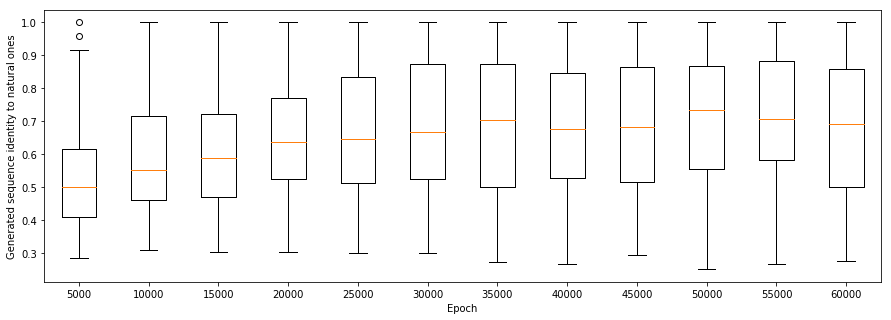

In [35]:
#identity box plot

data = identity_test
data = np.transpose(data)
labels = [str(5000*x) for x in range(int((num_epochs/5000)+1))]
labels.remove('0')

fs = 10

fig, axs = plt.subplots(figsize= (15,5))
axs.set_ylabel('Generated sequence identity to natural ones')
axs.set_xlabel('Epoch')
axs.boxplot(data, labels=labels)

plt.savefig('identity_figure.png') 
plt.show()

In [37]:
#Original  fasta format

with open("generated_seq.txt", 'w') as output: 
    
    for row in sequence_collect_test:
        if type(row) == list:
            i = 0
            for seq in row:
                i = i+1
                output.write(">seq" + str(i) + '\n' + ''.join(seq) + '\n')          
        else:
            output.write(str(row) + '\n')


In [38]:
torch.save(netG, 'netG.pkl') 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [39]:
### produce AMPs by the final trained model ###
final_Gan = torch.load('netG.pkl')

In [40]:
sequence_collect_produce = []

for num in range(25):
    produce_noise = torch.randn(128, nz, 1, 1, device=device)
    produce_fake_PC6_matrix = final_Gan(produce_noise)
    produce_fake_sequence = get_sequence_in_batch(produce_fake_PC6_matrix)
    
    sequence_collect_produce.extend([produce_fake_sequence])


In [41]:
produce_list = []
for row in sequence_collect_produce:
    for seq in row:
        
        seq_ = []
        for amino in seq:
            if amino != 'X':
                seq_.append(amino)
            else: 
                break
          
        produce_list.append(''.join(seq_))
                    


In [42]:
produce_list = random.choices(produce_list, k = 3195)
produce_list

['GLFLRNARKGAPNIIPAVAEHI',
 'GITGKIVVLLHTAAKTVICSINDKVTYT',
 'ILKKWPWWPWRRQIKKR',
 'FLHHIIRGIVHAGKTIHKLVRRRRR',
 'RQFKIWFQNRRLKQKK',
 'INWKKILPKIIKVAK',
 'AALKGCWTKSLPPKPCPGKR',
 'DWHSHVSHGVHGGGYVYVPFRK',
 'KGYRRLGRKIAHGVKKYGPCVLRIIRIAG',
 'RKWMWWWRKK',
 'KRLRRIIRHGVRLLKKYG',
 'ILGPVLGLVSNALGGLLKNI',
 'GACRALRHIPRRIR',
 'YHRLRDLLYIVTRIVDLLGRY',
 'DLWETLRRLLRWILAIPRRIRQGLELCI',
 'GFKDFLKGAVNAFVKMCTGHVC',
 'PFGSCMDAGSKIVGMTVGMFCKKKICKLS',
 'ILKKWPWWWWRR',
 'WWRWPWWPWRRK',
 'GLSGNYVPHGIAHILPLRAKPCSGEK',
 'MRPALIIFWPGIRRQS',
 'VWRVLVYALSIKIIGIAAISHYKKLL',
 'FDMVNSAGGVIGSLAMNK',
 'KWKLFKKIPKFLHLAKKF',
 'FRWCFRVCYRGFCRIKCR',
 'AWLDKLKSLGKVVGKVGIGVVEHYLDPKN',
 'DTHFPIMIFCCGCITRALCGMCTKS',
 'GFAKAFKKIVMVLKHISKYR',
 'GLYDILKGAAKNVVKTVVDHLKCKISGC',
 'ALYKKIKKKLIRSLKRLG',
 'KICHKVPYAGKPTRKCRK',
 'FLPLLVSGLPHILCFFFKKCN',
 'GLGSLLGSALKGGGNVIKWQKGGAPKNP',
 'GFKDWIKGAAKKLIKTVASHIANQ',
 'GVMGAIGKALGGCLTFWHNSKK',
 'ILPIKTFMKRGK',
 'FWPAILRLAVKVGPAVMCAITKNCE',
 'HVLSSIANGIDRALSFFG',
 'ALLDKLKEIGKVVGKVAL